<a href="https://www.kaggle.com/code/adrienmorel97/predicting-depression-with-ensemble-learning?scriptVersionId=214497669" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [35]:
# -------------------- For Data Visualization --------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- For Statistical Tests --------------------
from itertools import combinations
from scipy.stats import chi2_contingency, chi2

# -------------------- For Handling Missing Data --------------------
from sklearn.impute import SimpleImputer

# -------------------- For Preprocessing Data (Scaling, Encoding, etc.) --------------------
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer

# -------------------- For Building the Pipeline and Column Transformers --------------------
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline

# -------------------- For Creating Custom Transformers in the Pipeline --------------------
from sklearn.base import BaseEstimator, TransformerMixin

# -------------------- For Splitting Data into Train and Test Sets --------------------
from sklearn.model_selection import train_test_split

# -------------------- For Setting Scikit-Learn Configurations --------------------
from sklearn import set_config
set_config(display='diagram')

# -------------------- For Machine Learning Models --------------------
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# -------------------- For Model Evaluation Metrics --------------------
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, confusion_matrix

# -------------------- For Handling Warnings --------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# -------------------- For training time measurement --------------------
import time

# -------------------- For hyperparameter search --------------------
import optuna

### Importing the Dataset

In this step, we load the training and test datasets from the specified file paths. The datasets are read using `pandas.read_csv()`.

- **Training Data:** Loaded from `train.csv`.
- **Test Data:** Loaded from `test.csv`.

Additionally, a copy of the training data is created to avoid modifying the original dataset, which is stored in the variable `factors`.


In [36]:
# Importing the dataset from the specified path
data = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv')

# Creating a copy of the dataset to avoid modifying the original
factors = data.copy()

# Discover and visualize data

### Inspecting the First Few Rows of the Dataset

In this step, we display the first few rows of the `factors` DataFrame using the `head()` method. This allows us to get a quick overview of the structure and the initial records of the dataset, which helps in understanding the data before any processing or anasis..


In [37]:
factors.head()

id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No           0  
1               3.0                               No           1  
2               1.0                               No           1  
3               1.0                              Yes           1  
4               4.0                              Yes           0

### Displaying Summary Information about the Dataset

The `info()` method is used here to display summary information about the `factors` DataFrame. This includes:

- The number of entries (rows) in the dataset.
- The number of non-null values in each column.
- The data types of each column.

This step is useful for identifying missing values and understanding the structure of the dataset.


In [38]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

### Dropping the 'id' Column

In this step, we drop the 'id' column from the `factors` DataFrame using the `drop()` method. The `axis=1` argument specifies that we want to remove a column (not a row). The 'id' column is dropped because it is not needed for the analysis, as it does not contribute to the model or data processing.


In [39]:
factors = factors.drop(["id"], axis=1)

### Generating Summary Statistics

The `describe()` method is used to generate summary statistics for the `factors` DataFrame. This provides important statistical insights such as:

- Count, mean, standard deviation, minimum, and maximum values.
- The quartiles (25%, 50%, and 75%).

These statistics help in understanding the distribution of numeric features in the dataset, identifying potential outliers, and gaining insights into the data before further procssing.


In [40]:
factors.describe()

Age  Academic Pressure  Work Pressure          CGPA  \
count  140700.000000       27897.000000  112782.000000  27898.000000   
mean       40.388621           3.142273       2.998998      7.658636   
std        12.384099           1.380457       1.405771      1.464466   
min        18.000000           1.000000       1.000000      5.030000   
25%        29.000000           2.000000       2.000000      6.290000   
50%        42.000000           3.000000       3.000000      7.770000   
75%        51.000000           4.000000       4.000000      8.920000   
max        60.000000           5.000000       5.000000     10.000000   

       Study Satisfaction  Job Satisfaction  Work/Study Hours  \
count        27897.000000     112790.000000     140700.000000   
mean             2.944940          2.974404          6.252679   
std              1.360197          1.416078          3.853615   
min              1.000000          1.000000          0.000000   
25%              2.000000          2.000000          3.000000   
50%              3.000000          3.000000          6.000000   
75%              4.000000          4.000000         10.000000   
max              5.000000          5.000000         12.000000   

       Financial Stress     Depression  
count     140696.000000  140700.000000  
mean           2.988983       0.181713  
std            1.413633       0.385609  
min            1.000000       0.000000  
25%            2.000000       0.000000  
50%            3.000000       0.000000  
75%            4.000000       0.000000  
max            5.000000       1.000000

### Selecting Numeric and Object Columns

In this step, we separate the columns in the `factors` DataFrame based on their data types:

- **Numeric Columns:** The `select_dtypes()` method is used to select columns of type 'float' or 'int', which are stored in the `numeric_columns` variable.
- **Object Columns:** Similarly, columns of type 'object' (typically categorical or text data) are selected and stored in the `object_columns` variable.

This classification is useful for applying appropriate preprocessing steps, such as scaling for numeric columns or encoding for object clumns.


In [41]:
# Selecting numeric columns (of type 'float' or 'int') from the 'factors' DataFrame
numeric_columns = factors.select_dtypes(include=['float', 'int']).columns

# Selecting object columns (of type 'object') from the 'factors' DataFrame
object_columns = factors.select_dtypes(include=['object']).columns

## Visualizing Distributions of Numeric Variables

In this step, we create a grid of histograms to visualize the distribution of numeric variables:

- **Grid Layout:** The number of rows and columns for the grid is dynamically calculated based on the total number of numeric variables (`numeric_columns`), with a fixed number of columns (`num_cols`).
- **Subplots Creation:** A grid of subplots is created using `matplotlib`, where each subplot corresponds to a histogram of a numeric variable.
- **Histogram Customization:** 
  - The number of bins is determined dynamically, with a fixed number of bins for the 'CGPA' column.
  - The histograms are customized with Seaborn's `histplot()` function, adding a Kernel Density Estimate (KDE) line with customized color and width for smoother visualization.
  - Plot aesthetics are improved by removing gridlines, ticks, and plot borders (spines).
- **Final Adjustments:** Unused subplots (if any) are removed, and the layout is adjusted for a cleaner presentation.

This approach provides an insightful visual overview of the distribution of each numeric variable in the dataset.


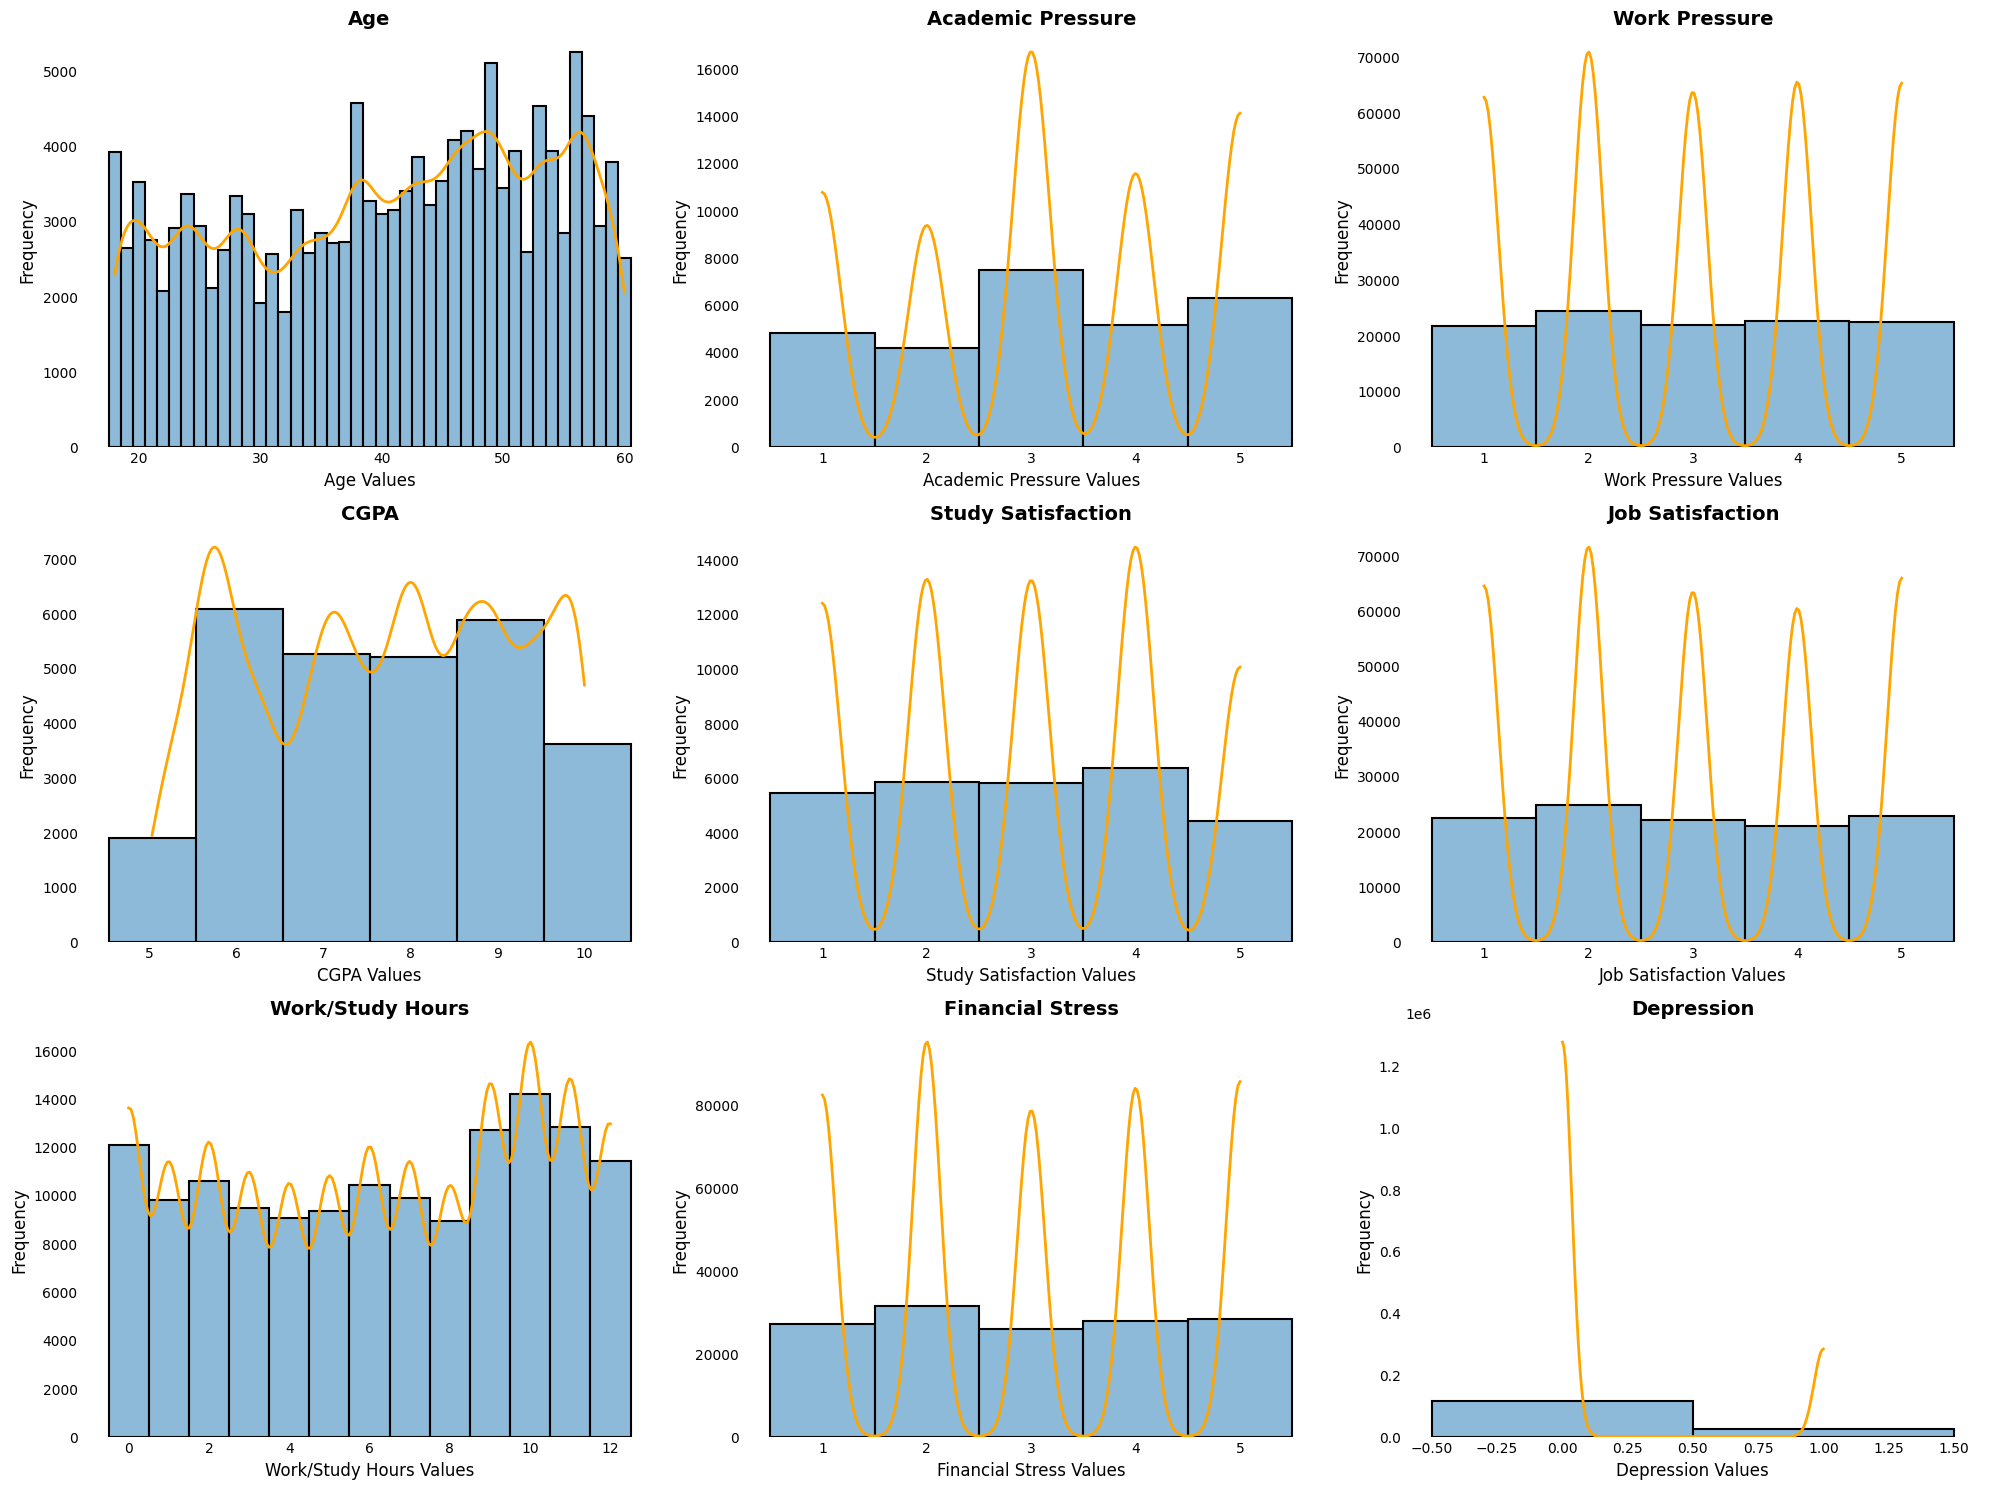

In [42]:
# Calculate the number of rows and columns required for the subplot grid
num_vars = len(numeric_columns)  # Total number of numeric variables
num_cols = 3  # You can adjust this number based on your preferences
num_rows = (num_vars + num_cols - 1) // num_cols  # Calculate the number of rows needed to fit all plots

# Create the grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array to make it easier to iterate

# Plot a histogram for each numeric variable with customized bins and styling
for ax, col in zip(axes, numeric_columns):
    # Determine the number of bins: use the number of unique values, except for 'CGPA'
    if col == 'CGPA':
        bins = 30  # Set a fixed number of bins for CGPA
    else:
        bins = len(factors[col].unique())  # Set bins equal to the number of unique values

    # Plot the histogram with Seaborn's histplot (no KDE line yet)
    sns.histplot(factors[col], bins=bins, ax=ax, kde=True, edgecolor="black", 
                 linewidth=1.5, discrete=True)

    # Get the current axes and the lines from the KDE plot
    for line in ax.lines:
        # Adjust the KDE line properties: set color and linewidth
        if isinstance(line, plt.Line2D):  # Ensure it is a line (the KDE line is a Line2D object)
            line.set_color('orange')  # Set KDE line color
            line.set_linewidth(2)  # Set KDE line width

    # Set the title and labels for a cleaner look
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{col} Values', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Remove grid and ticks for a cleaner look
    ax.grid(False)  # Disable gridlines
    ax.tick_params(axis='both', which='both', length=0)  # Remove ticks
    
    # Remove the frame (spines) around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

# Remove unused subplots if the number of variables is less than the number of subplots
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Visualizing Distributions and Relationships with 'Depression' Levels

In this step, we visualize the distributions of numeric variables in relation to 'Depression' levels:

- **Filtered Numeric Columns:** The 'Depression' column is excluded from the list of numeric columns to focus on other variables.
- **Subplots Grid:** A grid of subplots is created, with each row corresponding to a numeric variable from the filtered list. Each row contains three plots:
  - **Density Plot:** The left column shows the distribution of the numeric variable using a KDE plot, with the area under the curve filled to emphasize the density.
  - **Boxplot:** The middle column displays a boxplot showing the distribution of each variable grouped by the 'Depression' levels.
  - **KDE Plot by 'Depression':** The right column shows a KDE plot with a hue based on 'Depression', allowing us to compare the distributions of each variable across different depression levels.
- **Plot Customization:** Aesthetic improvements are applied by adjusting titles, labels, and plot properties. The layout is optimized using `tight_layout()` to ensure plots are spaced properly.

This step provides a deeper understanding of how each numeric variable is distributed and how its distribution relates to 'Depression' levels.


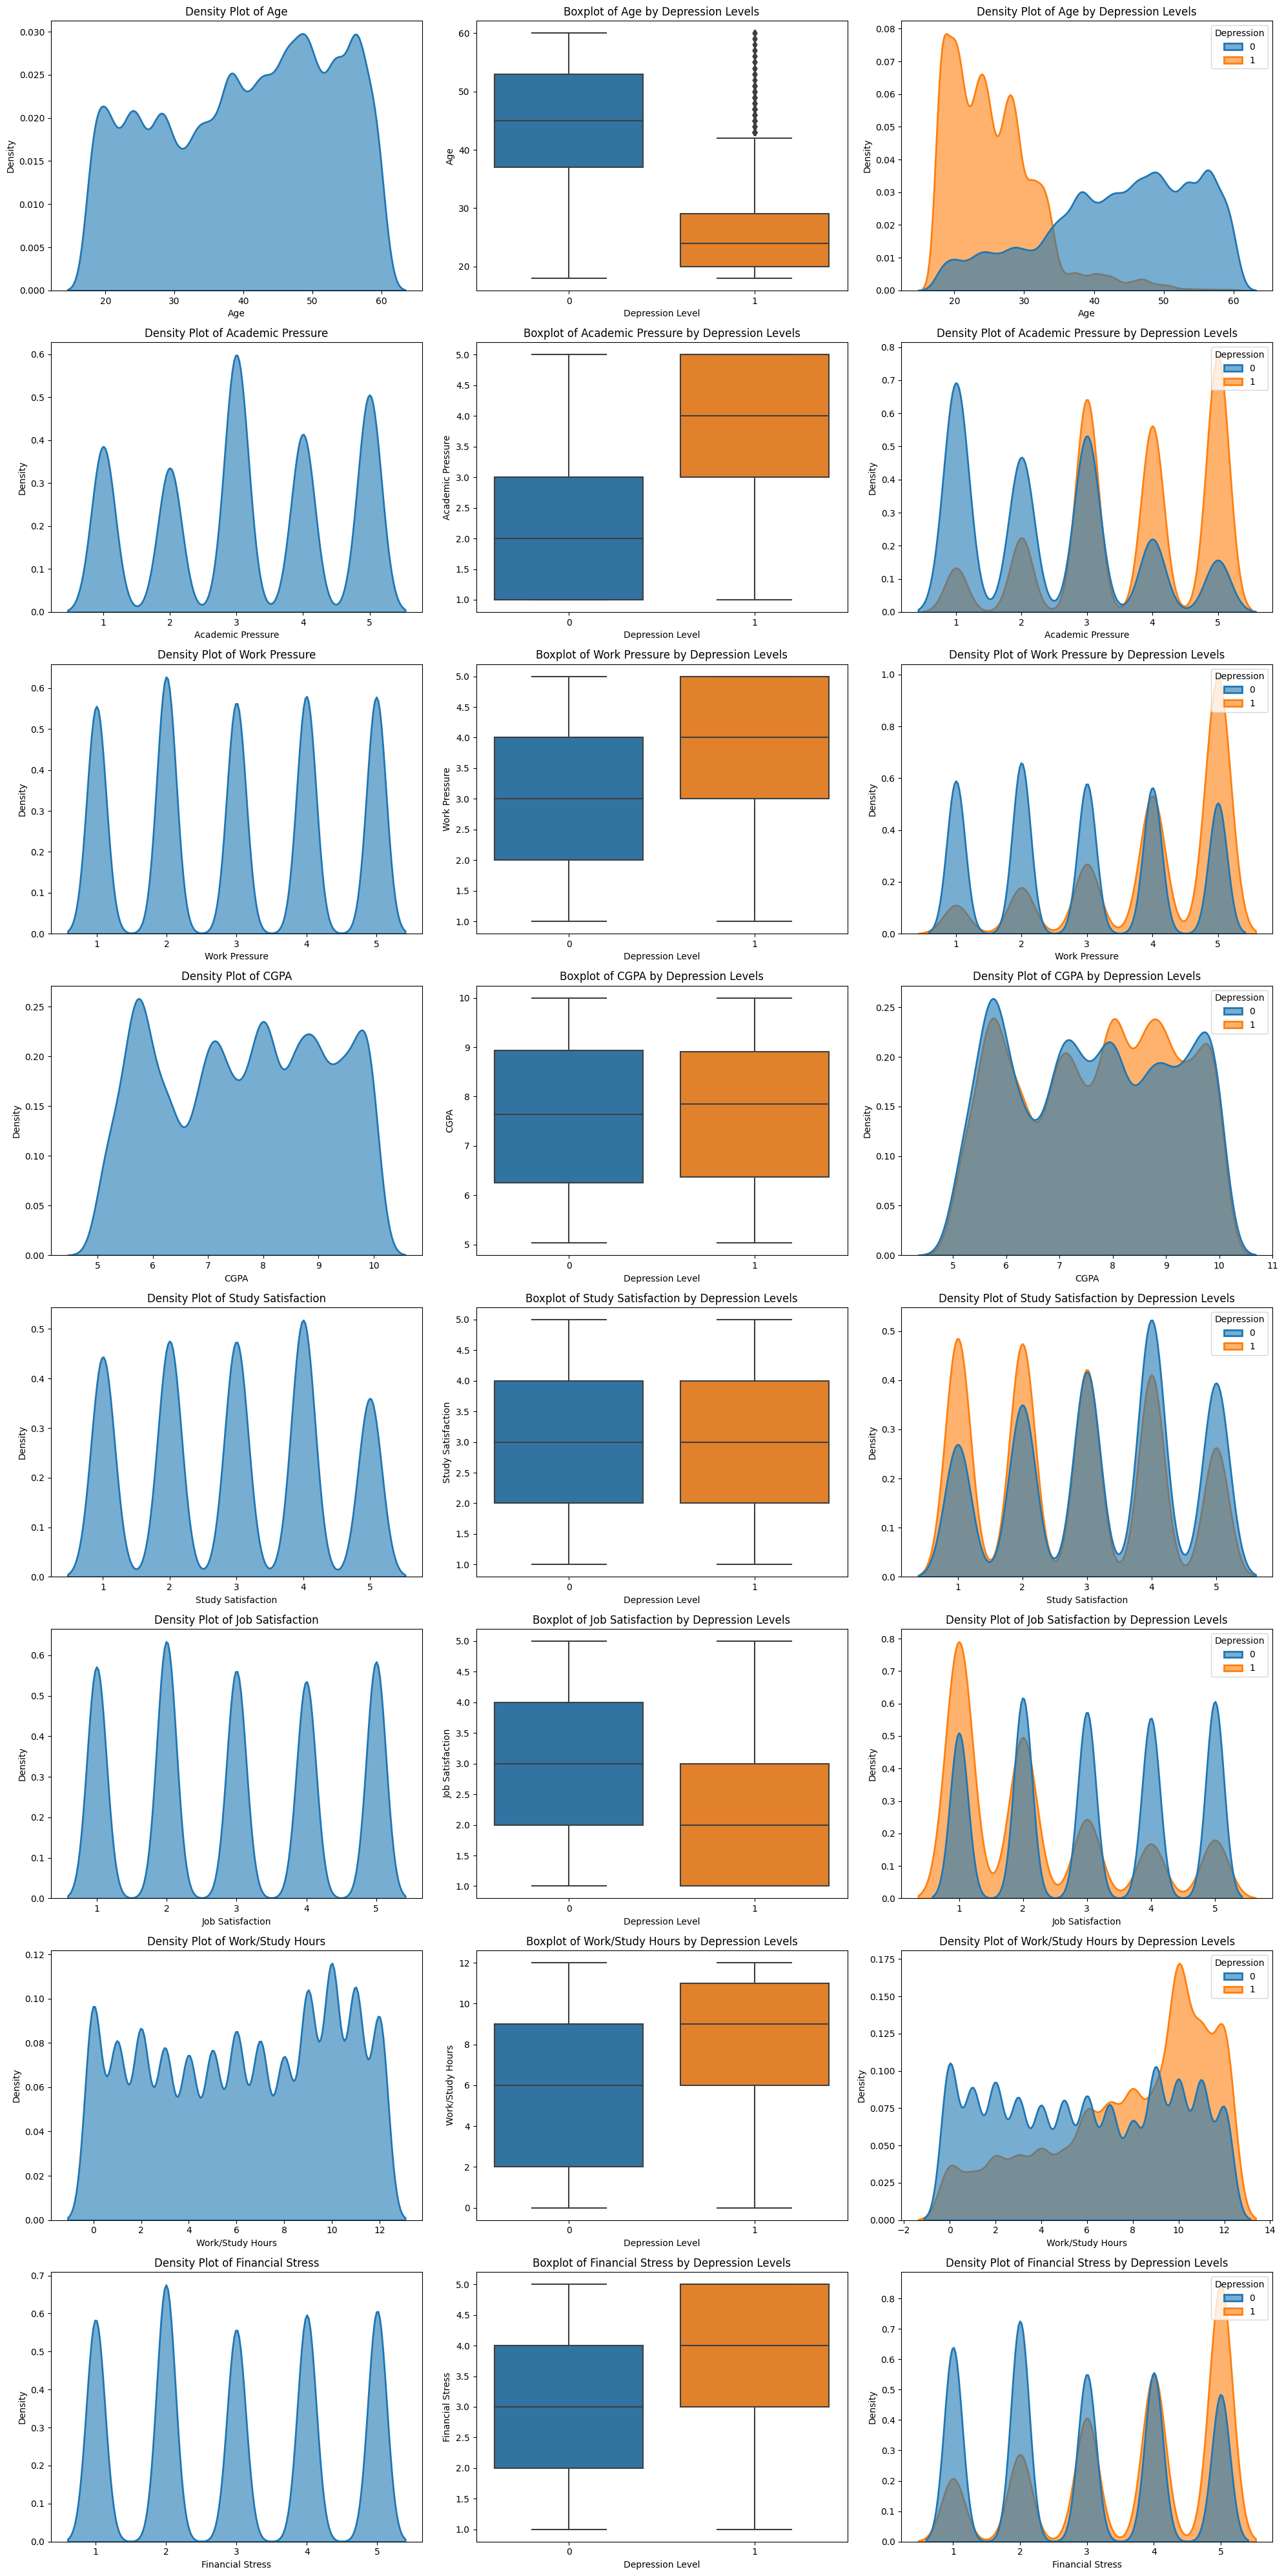

In [43]:
# Filter out the 'Depression' column from the list of numeric columns
filtered_numeric_columns = [col for col in numeric_columns if col != "Depression"]

# Create a grid of subplots for the density and histograms
fig, axes = plt.subplots(len(filtered_numeric_columns), 3, figsize=(20, 5 * len(filtered_numeric_columns)))

# Loop through each variable and create a histogram, KDE plot, and customized KDE line
for i, var in enumerate(filtered_numeric_columns):
    # Calculate the number of unique values in the column for dynamic binning
    unique_values = len(factors[var].unique())

    # Density plot in the right column
    sns.kdeplot(data=factors, x=var, fill=True, common_norm=False, alpha=0.6, ax=axes[i, 0], linewidth=2)
    axes[i, 0].set_title(f"Density Plot of {var}")
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel("Density")
    
    # Boxplot in the middle column (not changing)
    sns.boxplot(data=factors, x='Depression', y=var, ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {var} by Depression Levels")
    axes[i, 1].set_xlabel("Depression Level")
    axes[i, 1].set_ylabel(var)

    # KDE plot in the right column with hue (using color palette)
    sns.kdeplot(data=factors, x=var, hue='Depression', fill=True, common_norm=False, alpha=0.6, ax=axes[i, 2], linewidth=2)
    axes[i, 2].set_title(f"Density Plot of {var} by Depression Levels")
    axes[i, 2].set_xlabel(var)
    axes[i, 2].set_ylabel("Density")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## Calculating Correlations with 'Depression'

In this step, we calculate the correlation matrix for all numeric variables in the dataset. The correlation values provide insights into the linear relationships between pairs of variables. 

- **Correlation with 'Depression':** We specifically extract the correlations between the 'Depression' variable and other numeric variables, sorting them in descending order based on the strength of the correlation.
- **Formatting the Results:** The correlation values are rounded to three decimal places, and the results are presented in a clean, styled table with alternating row colors and a color gradient that highlights stronger correlations.

This table provides an overview of which numeric variables are most strongly correlated with 'Depression', helping us understand potential relationships for further analysis or modeling.


In [44]:
# Calculate the correlation matrix
correlation_matrix = factors[numeric_columns].corr()

# Extract correlations with the "Depression" column
correlations_with_depression = (
    correlation_matrix["Depression"]  # Get only the "Depression" column
    .drop("Depression")  # Remove the correlation of "Depression" with itself
    .reset_index()  # Convert to a DataFrame
)
correlations_with_depression.columns = ["Variable", "Correlation"]  # Rename columns

# Sort by correlation values in descending order
correlations_with_depression = correlations_with_depression.sort_values(by="Correlation", ascending=False).round(3)

# Apply Pandas styling for a clean and colorful output
styled_correlation_table = correlations_with_depression.style \
    .background_gradient(cmap='coolwarm', subset=["Correlation"]) \
    .set_table_styles([{'selector': 'th', 'props': [('background-color', '#f5f5f5')]},  # Set header background color
                       {'selector': 'td', 'props': [('text-align', 'center')]},  # Center-align table content
                       {'selector': 'table', 'props': [('border-collapse', 'collapse')]},  # Collapse table borders
                       {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},  # Alternating row colors
                       {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},])  # Alternating row colors


# Display the styled table
styled_correlation_table


## Visualizing Category Counts for Object-Type Columns

In this step, we create count plots for each categorical (object-type) column to visualize the distribution of categories:

- **Loop Through Object Columns:** The code loops through each object column in the dataset.
- **Count Calculation and Plotting:** 
  - The `value_counts()` method is used to determine the frequency of each category within the column, and the categories are ordered accordingly.
  - Seaborn's `countplot()` is used to create the plot with a blue color palette (`Blues_d`).
- **Customization:** 
  - Titles and labels are added to the plot for clarity.
  - The x-axis labels are rotated if needed to ensure readability.
  - The plot's top and right borders are removed using `sns.despine()` for a cleaner presentation.
- **Annotations:** 
  - Each bar is annotated with the count value, with conditional rotation of annotations based on the number of categories. For columns with more than 10 categories, annotations are rotated by 90 degrees to avoid overlap.

These count plots help us visually assess the distribution of categories for each object-type feature in the dataset.


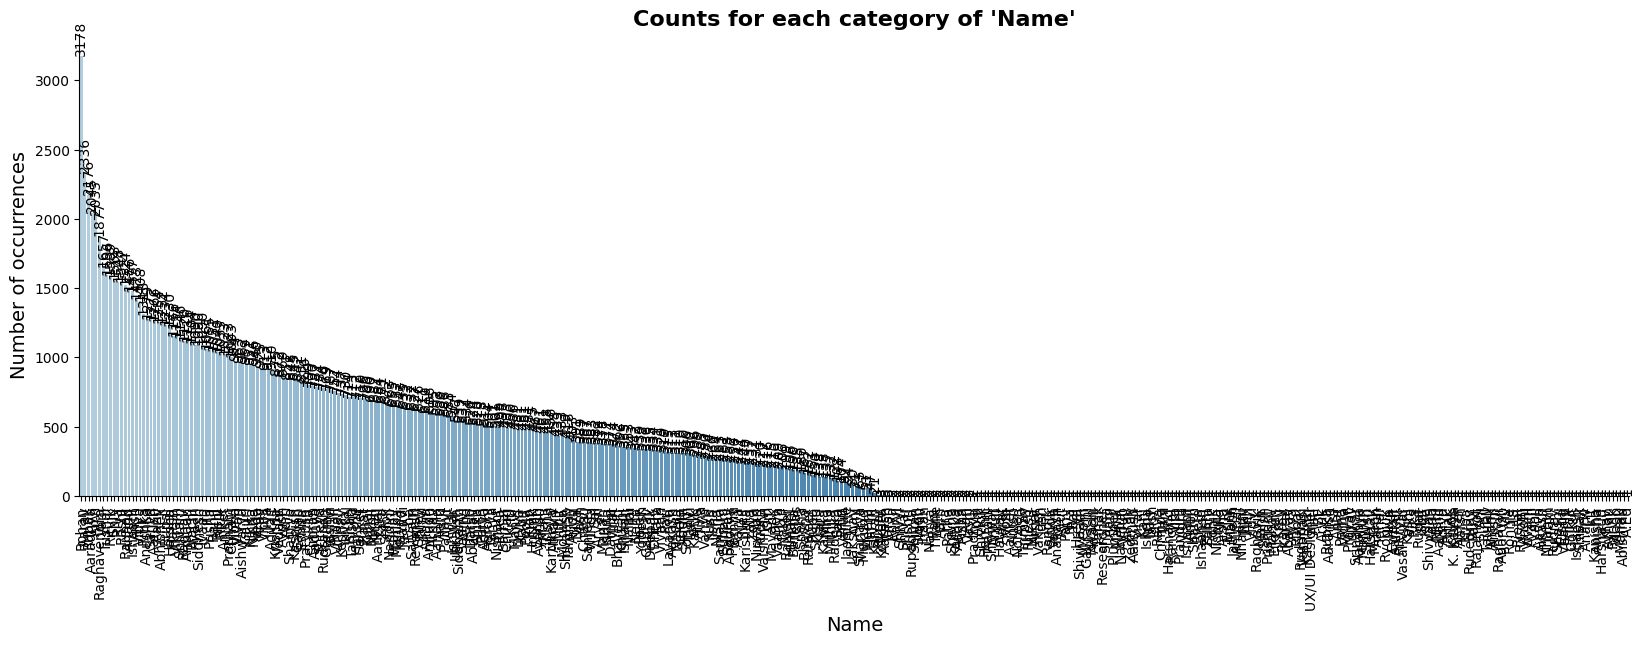

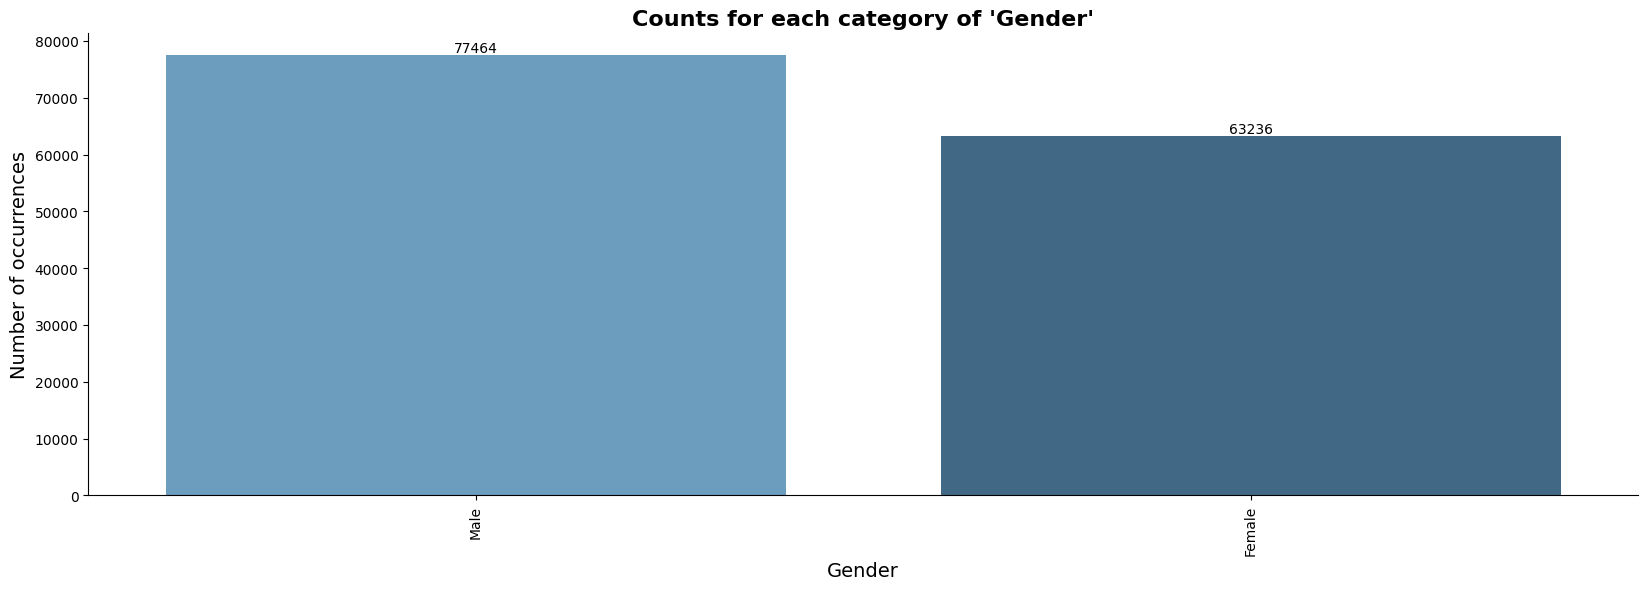

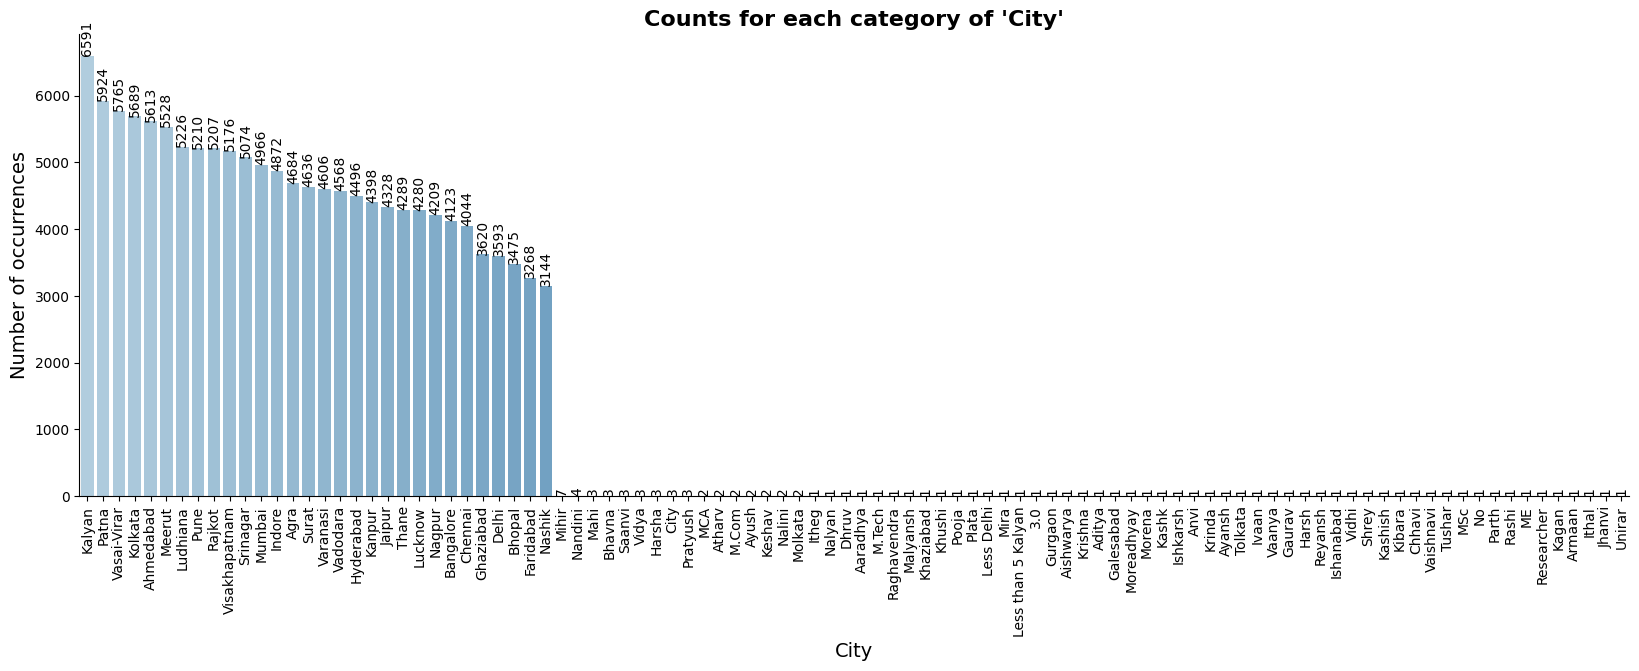

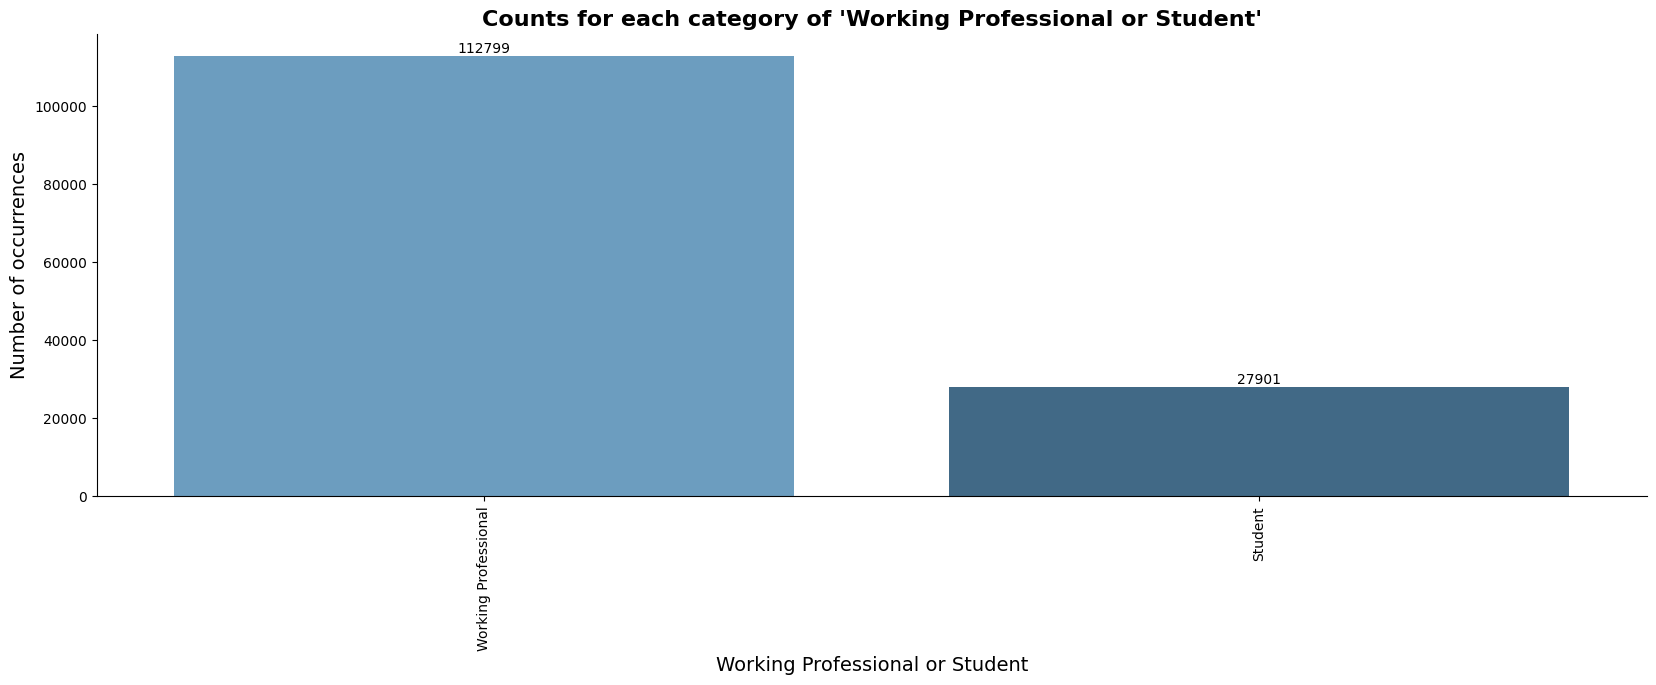

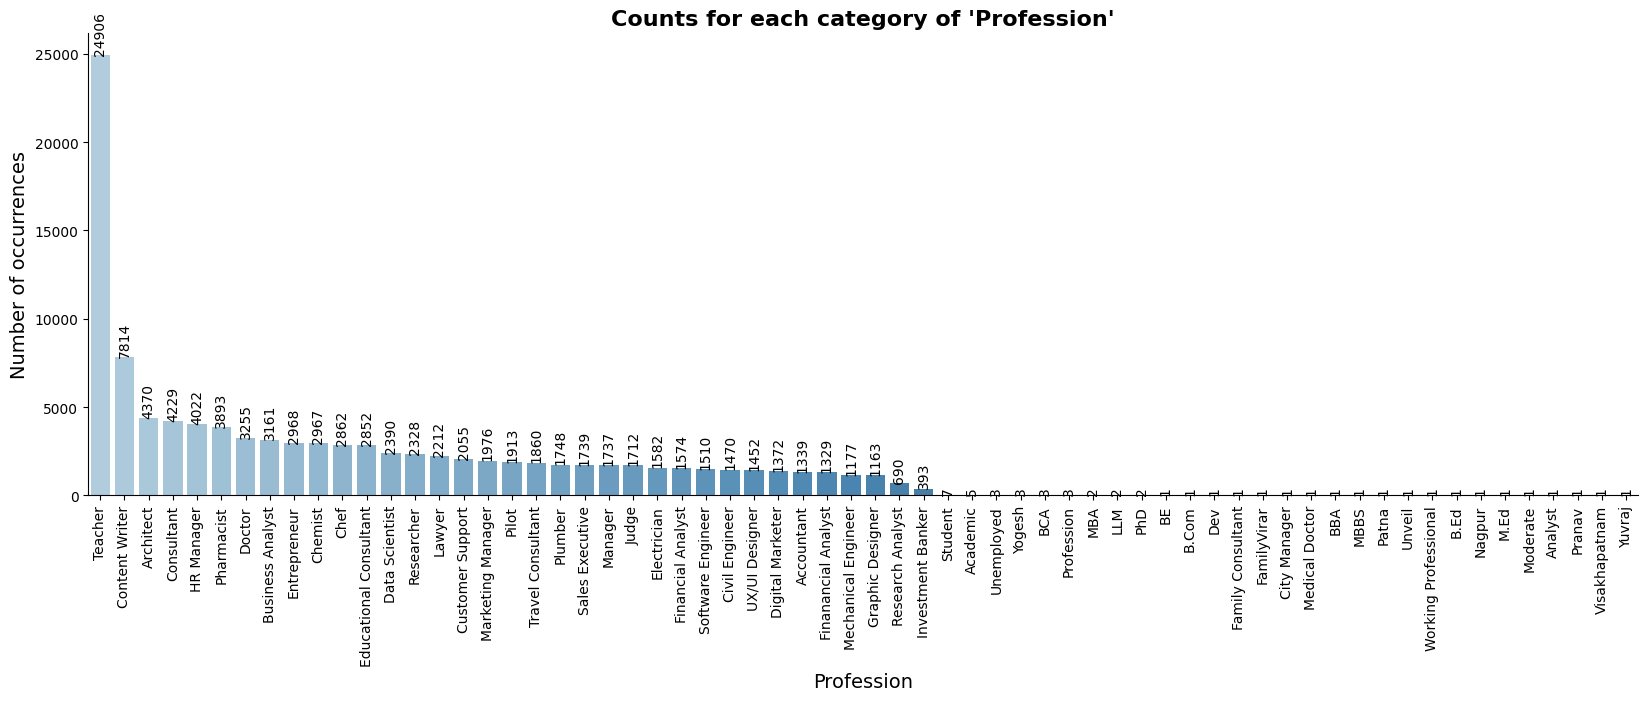

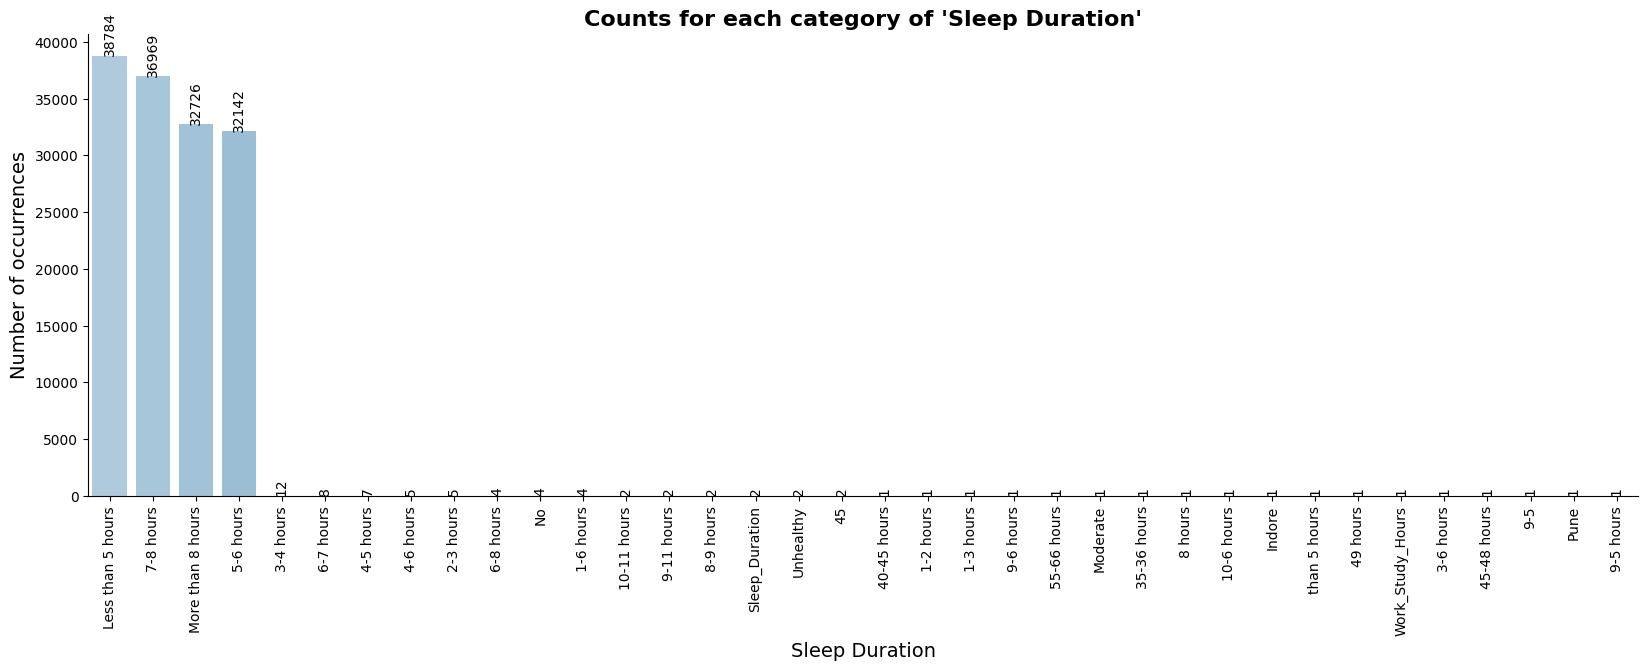

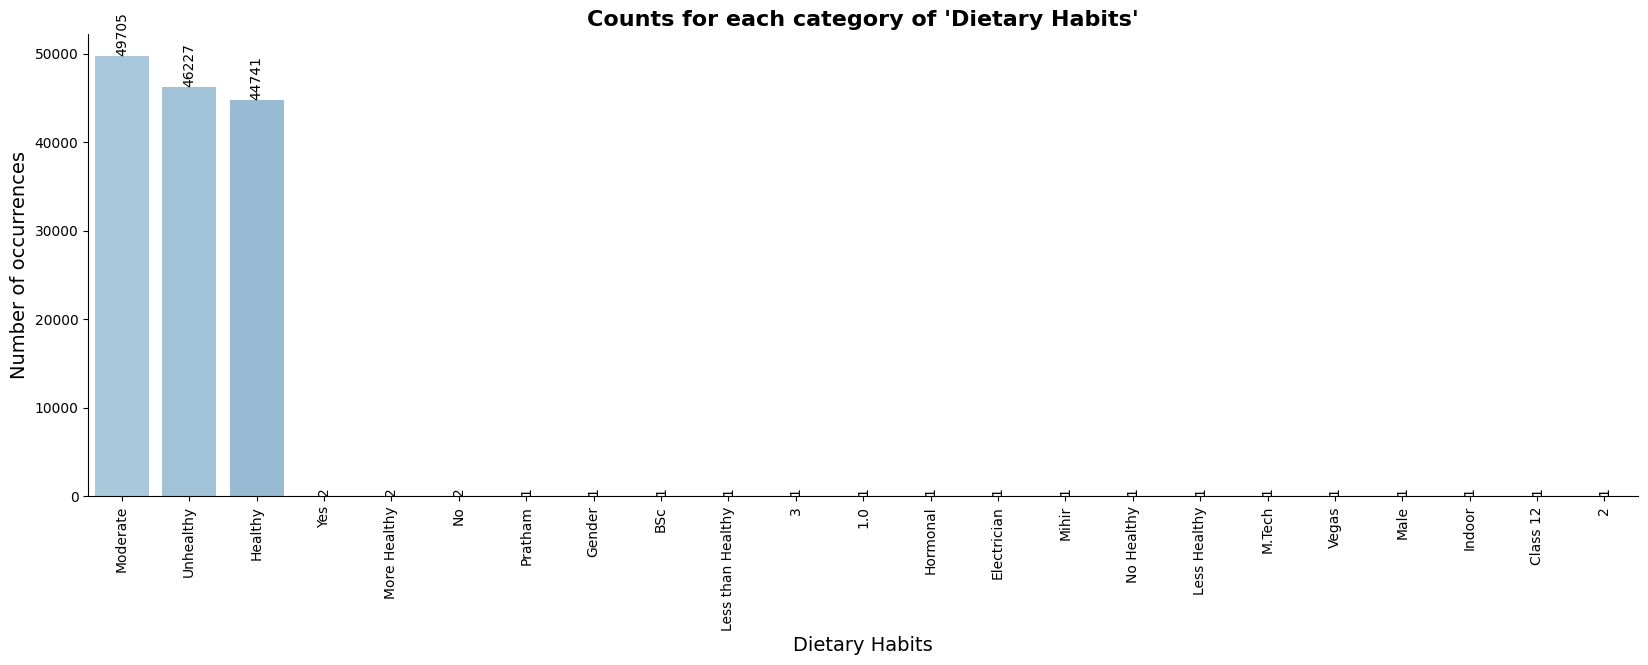

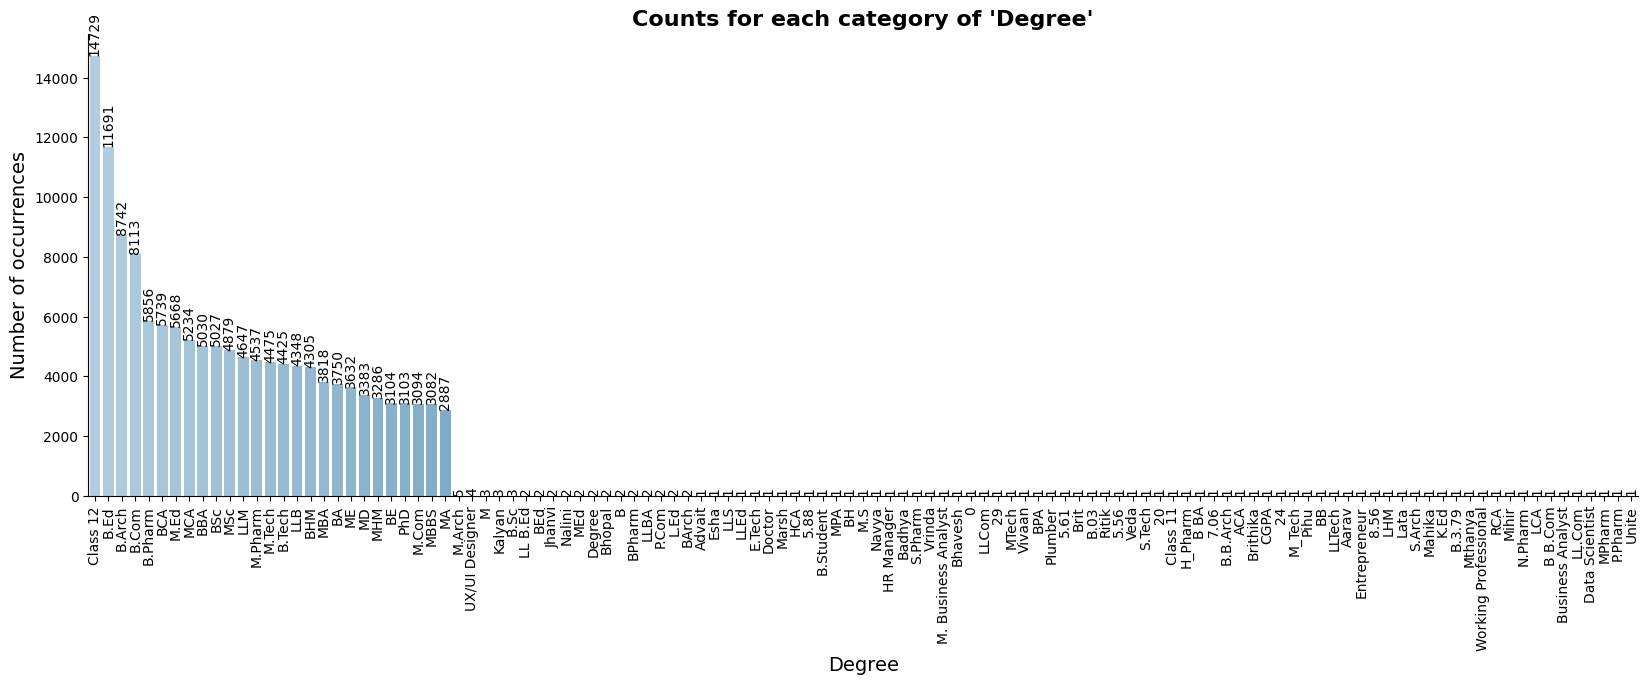

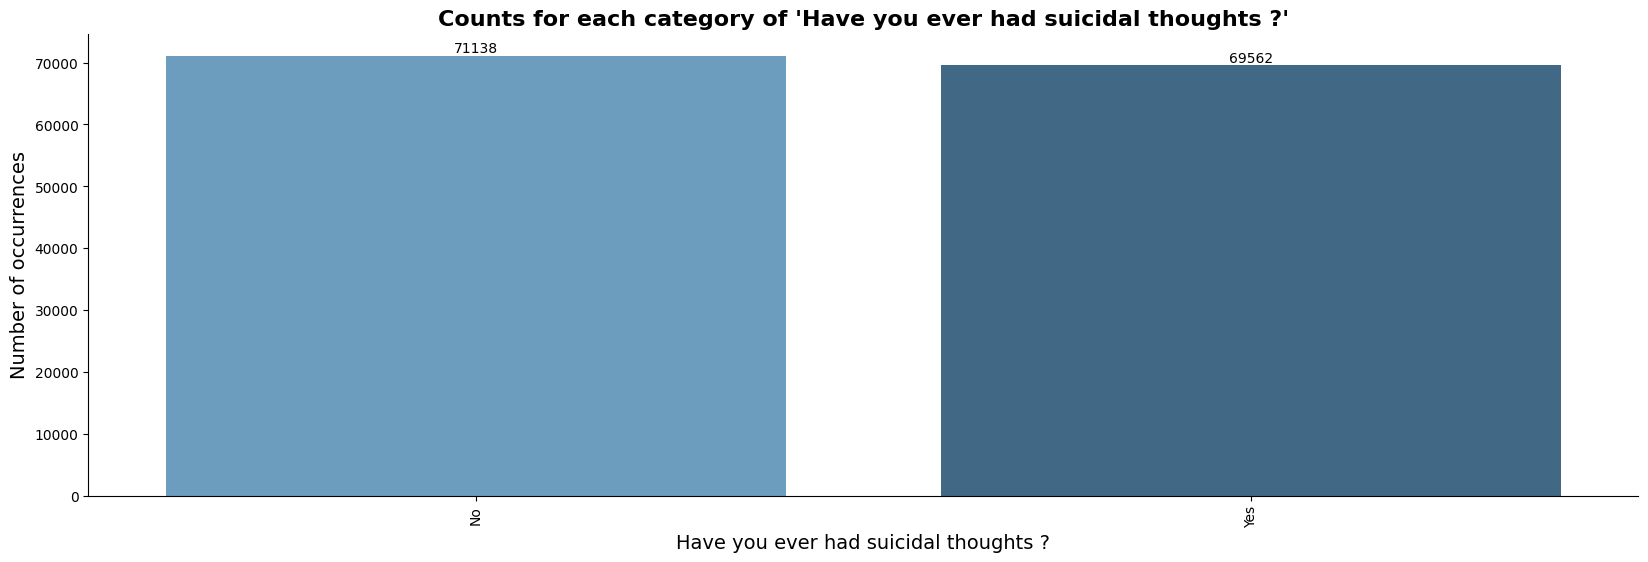

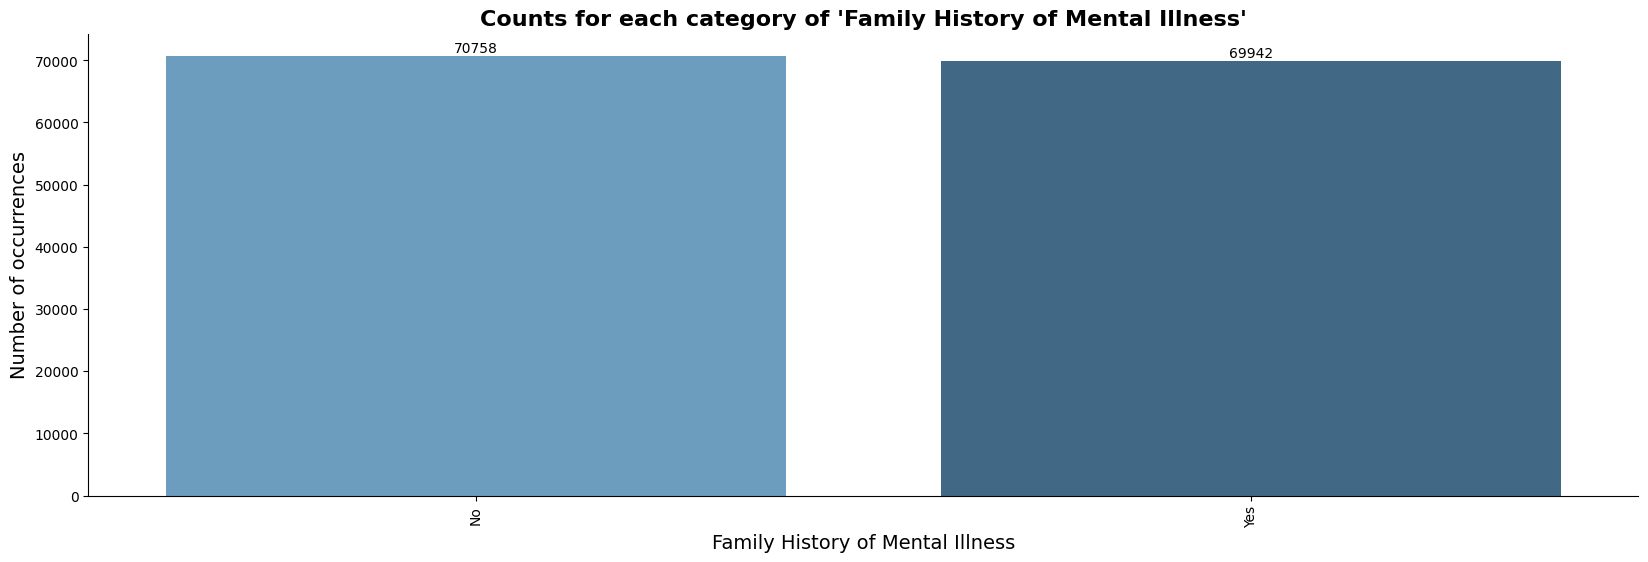

In [45]:
# Loop through each object type column
for col in object_columns:

    # Set the figure size for each plot
    plt.figure(figsize=(20, 6))
    
    # Get the counts of each category and order them
    counts = data[col].value_counts()
    order = counts.index
    
    # Plot the count plot using Seaborn with a blue color palette
    ax = sns.countplot(x=col, data=factors, order=order, palette="Blues_d")
    
    # Set the title and labels for the plot
    ax.set_title(f"Counts for each category of '{col}'", fontsize=16, fontweight='bold')
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("Number of occurrences", fontsize=14)
    
    # Rotate the x-axis labels if needed to make them readable
    plt.xticks(rotation=90, fontsize=10)
    
    # Remove the top and right borders for a cleaner look
    sns.despine()
    
    # Conditionally annotate the bars with the corresponding count values
    for p in ax.patches:
        height = p.get_height()  # Get the height (count) of each bar
        if len(order) > 10:  # If there are more than 10 bars, rotate the annotation
            ax.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2, height),  # Position of the annotation
                        ha='center', va='bottom', fontsize=10, rotation=90)  # Rotate by 90 degrees
        else:
            ax.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2, height),  # Position of the annotation
                        ha='center', va='bottom', fontsize=10)  # No rotation
    
    # Show the plot
    plt.show()

# Data Preprocessing

## Handling Text and Categorical Attributes

### Identifying and Storing Frequent Values in Object-Type Columns

In this step, we identify and store the values that occur more than 20 times in each object-type column:

- **Looping Through Object Columns:** The code iterates over each object-type column in the dataset.
- **Counting Occurrences:** For each column, the `value_counts()` method is used to get the frequency of each category.
- **Filtering Frequent Values:** Only values with more than 20 occurrences are selected using conditional filtering.
- **Storing Results:** A temporary DataFrame is created for the frequent values and their counts. This DataFrame is then concatenated to a larger DataFrame (`factors_frequent_values`), which stores the results for all object columns.

The resulting DataFrame `factors_frequent_values` contains the object columns, their frequent values, and the corresponding counts, providing insight into the most common categories in each column.


In [46]:
# Initialize an empty DataFrame to store the results
factors_frequent_values = pd.DataFrame()

# Loop through each column of object type
for col in object_columns:
    # Get the counts of each category in the column
    value_counts = factors[col].value_counts()
    
    # Select values that have more than 20 occurrences
    frequent_values = value_counts[value_counts > 20]
    
    # Create a temporary DataFrame for these frequent values
    temp_df = pd.DataFrame({
        'variable': [col] * len(frequent_values),  # Repeat the column name for each frequent value
        'value': frequent_values.index,  # The unique value
        'count': frequent_values.values  # The corresponding count
    })
    
    # Concatenate the temporary DataFrame to the result DataFrame
    factors_frequent_values = pd.concat([factors_frequent_values, temp_df], ignore_index=True)

# Display the results
factors_frequent_values

variable     value  count
0                                     Name     Rohan   3178
1                                     Name     Aarav   2336
2                                     Name     Rupak   2176
3                                     Name  Aaradhya   2045
4                                     Name      Anvi   2035
..                                     ...       ...    ...
319                                 Degree        MA   2887
320  Have you ever had suicidal thoughts ?        No  71138
321  Have you ever had suicidal thoughts ?       Yes  69562
322       Family History of Mental Illness        No  70758
323       Family History of Mental Illness       Yes  69942

[324 rows x 3 columns]

### Filtering Object Columns to Retain Only Frequent Values

In this step, we filter the object-type columns to keep only the most frequent values:

- **Copying the Original DataFrame:** A copy of the `factors` DataFrame is created to avoid modifying the original data.
- **Looping Through Frequent Values:** The code iterates through each unique categorical variable in the `factors_frequent_values` DataFrame.
- **Filtering:** For each column, the frequent values (those occurring more than 20 times) are identified. Any values not in the list of frequent values are replaced with `NaN` in the `factors_filtered` DataFrame.
  
This results in a filtered version of the dataset where only the most frequent categories are retained in the object-type columns, helping focus the analysis on common values while handling rare categories as missing data.


In [47]:
# Copy the original DataFrame for filtering
factors_filtered = factors.copy()

# Loop through each unique categorical variable in factors_frequent_values
for col in factors_frequent_values['variable'].unique():
    # Get the frequent values for the current column from factors_frequent_values
    frequent_values = factors_frequent_values[factors_frequent_values['variable'] == col]['value']
    
    # Replace values not in frequent values with NaN for the current column
    factors_filtered.loc[~factors_filtered[col].isin(frequent_values), col] = np.nan

### Analyzing Category Distribution by 'Depression' Ratio

In this step, we analyze the distribution of object-type variables in relation to the 'Depression' column:

- **Grouping and Counting:** For each object column, the data is grouped by both the categorical variable and 'Depression', and the count of occurrences is calculated.
- **Calculating Depression Ratio:** The ratio of 'Depression=True' is computed for each category, representing the percentage of individuals in each category who have depression. This ratio is then sorted in descending order.
- **Visualization:** A stacked bar plot is created using Seaborn's `barplot()` function:
  - The bars represent the count of occurrences for each category, stacked by the 'Depression' status.
  - The categories are ordered by the depression ratio.
  - The x-axis labels display the category names along with their corresponding depression ratios.
- **Customization:** Titles, axis labels, and annotations are added to improve readability. The x-axis labels are rotated for clarity, and annotations are conditionally rotated based on the number of categories.

This visualization helps in understanding how the categories of each object-type variable relate to the presence of depression, highlighting which categories have higher or lower proportions of individuals with depression.


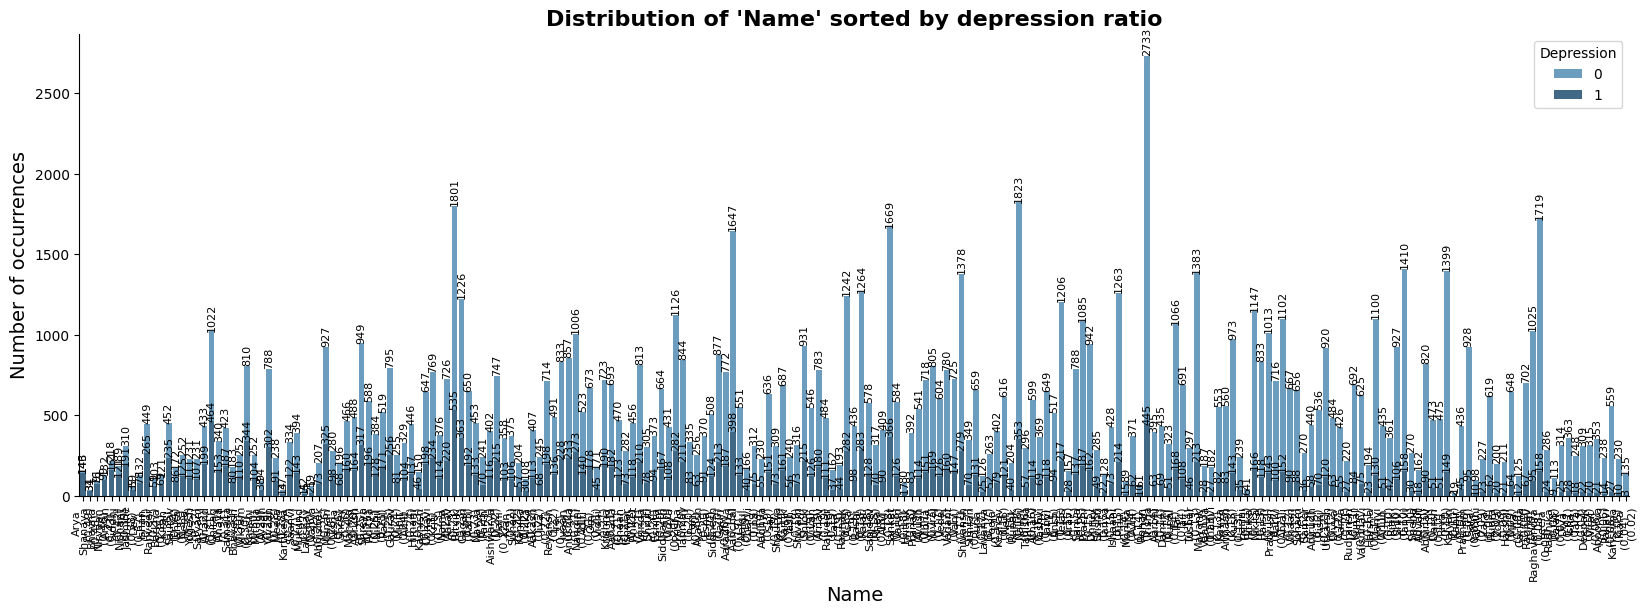

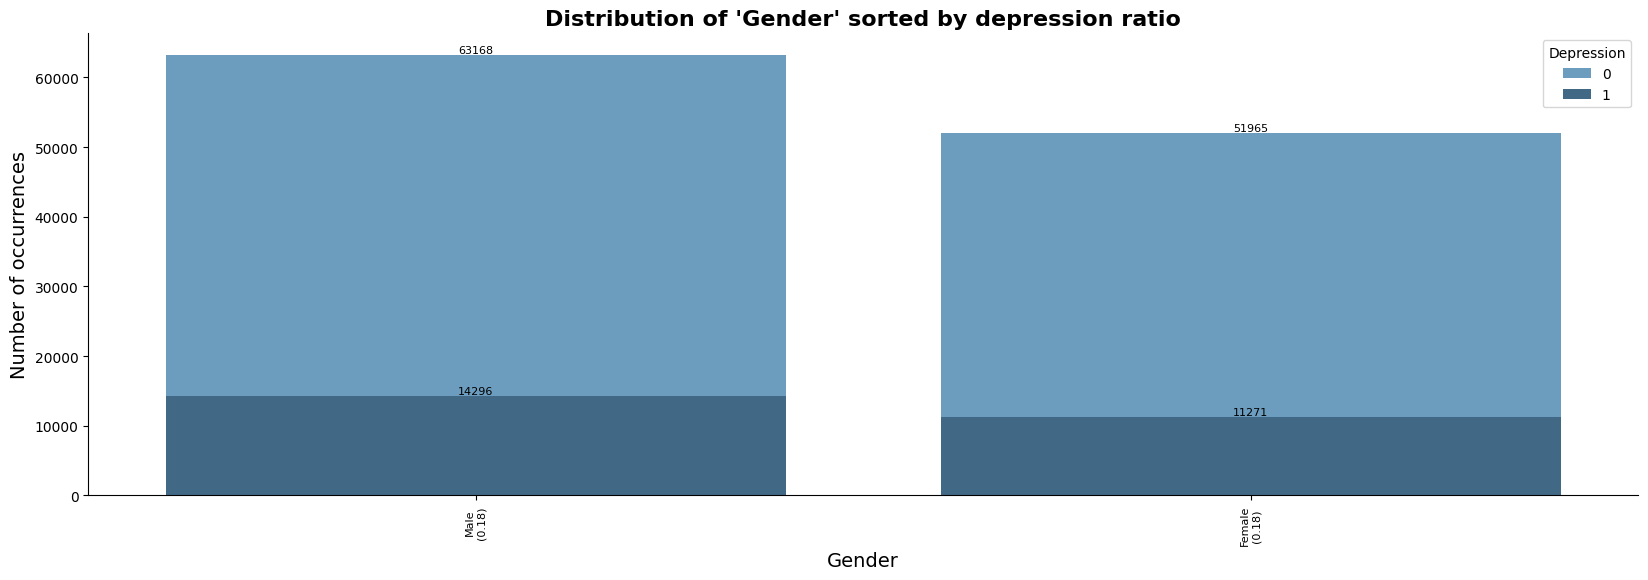

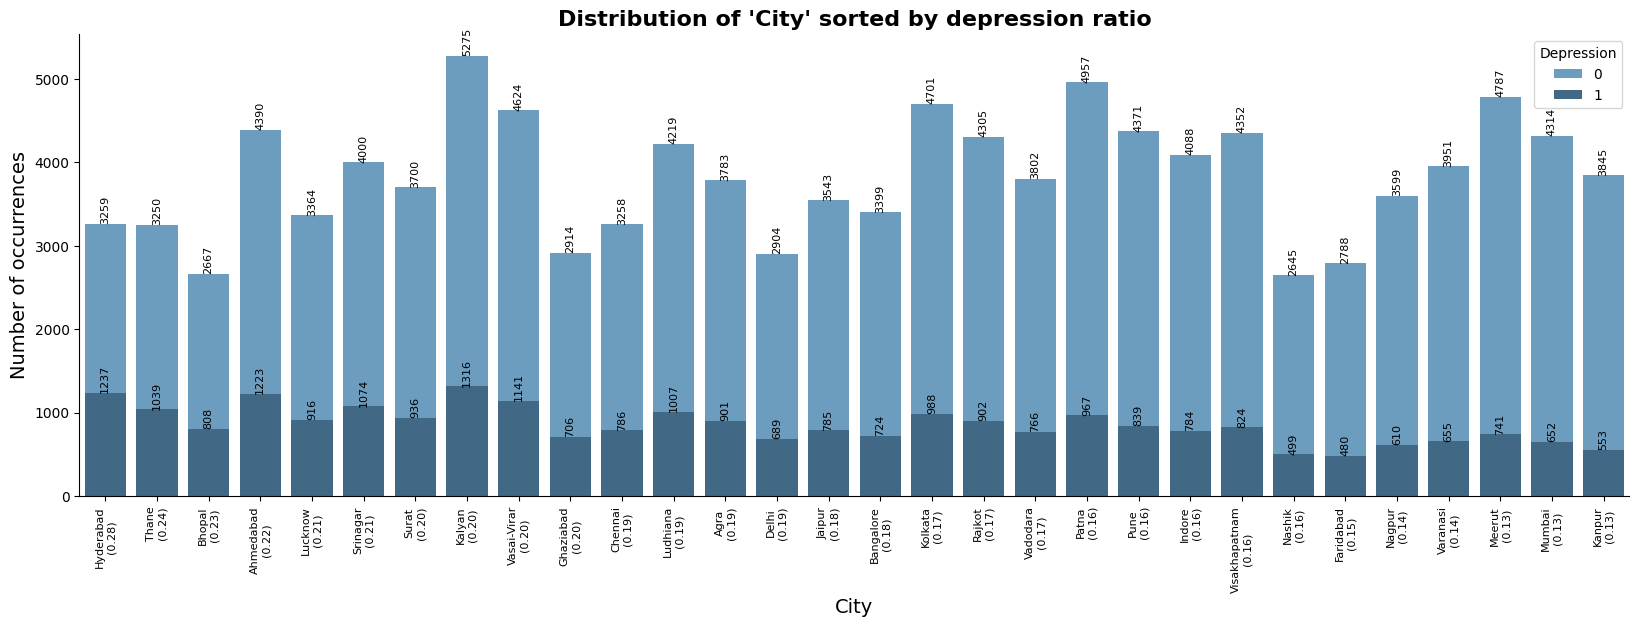

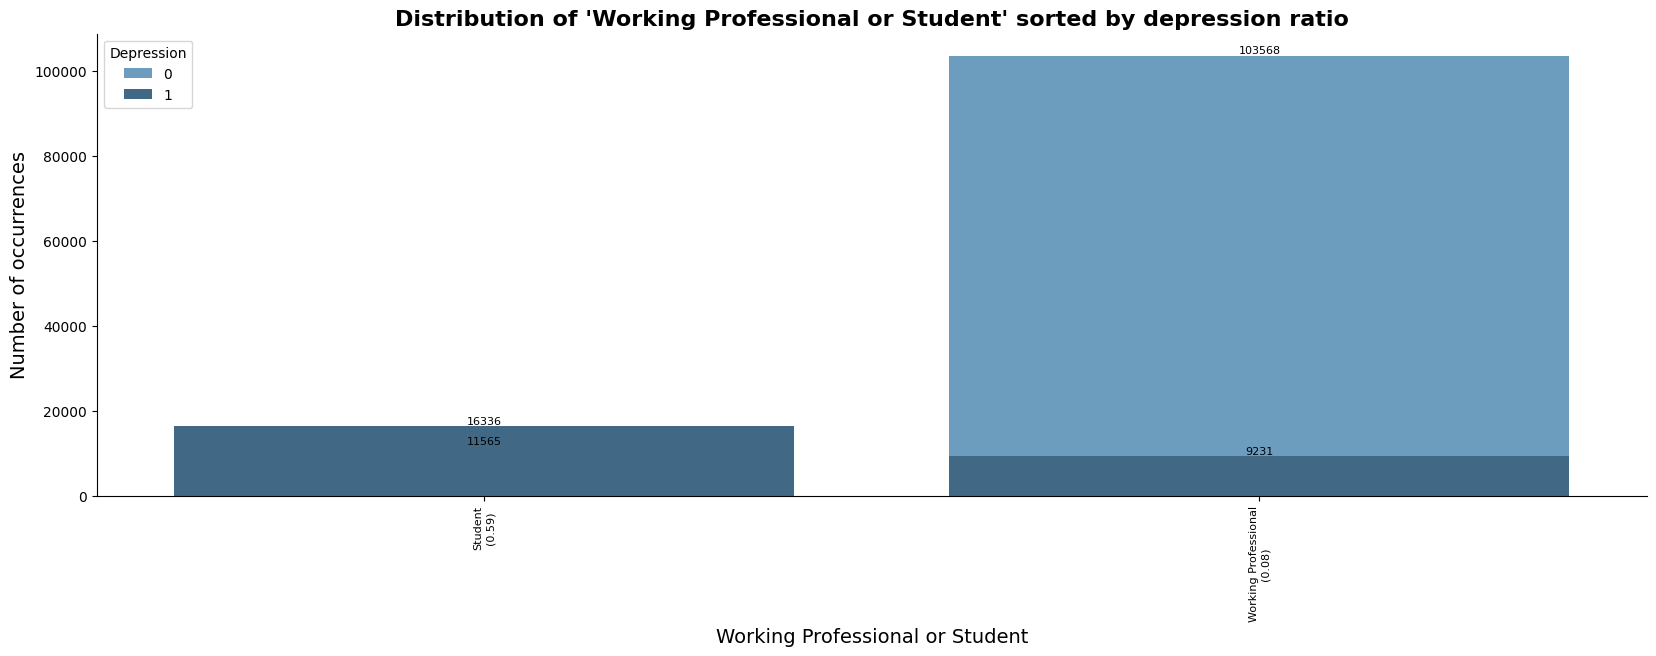

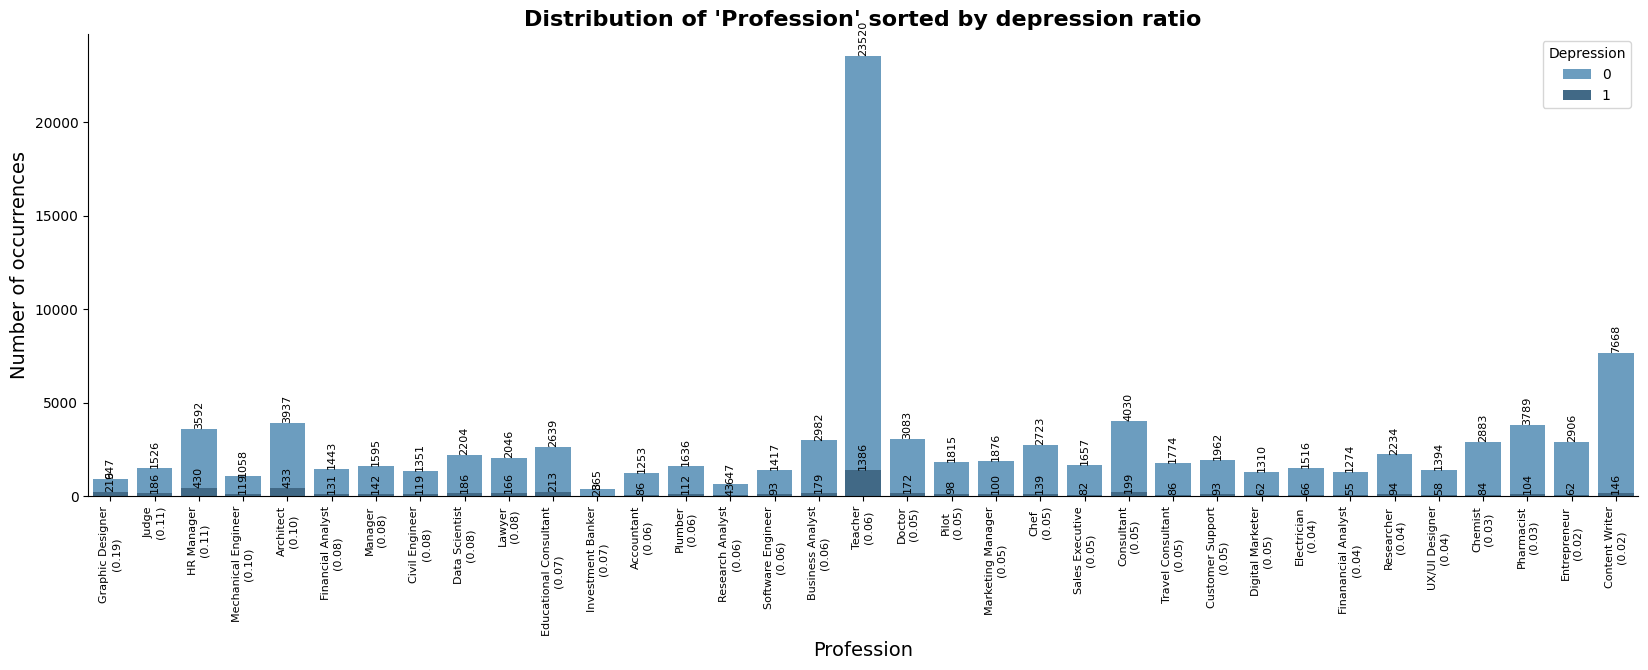

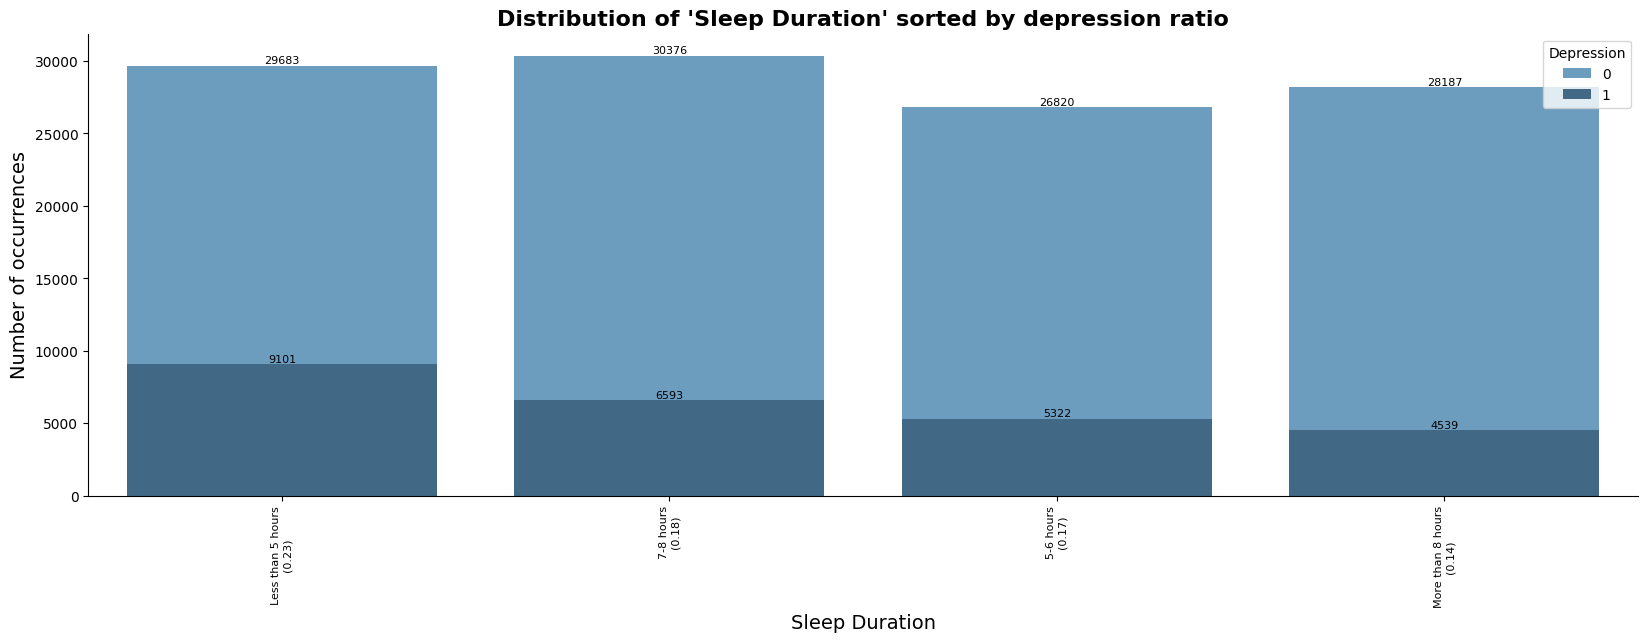

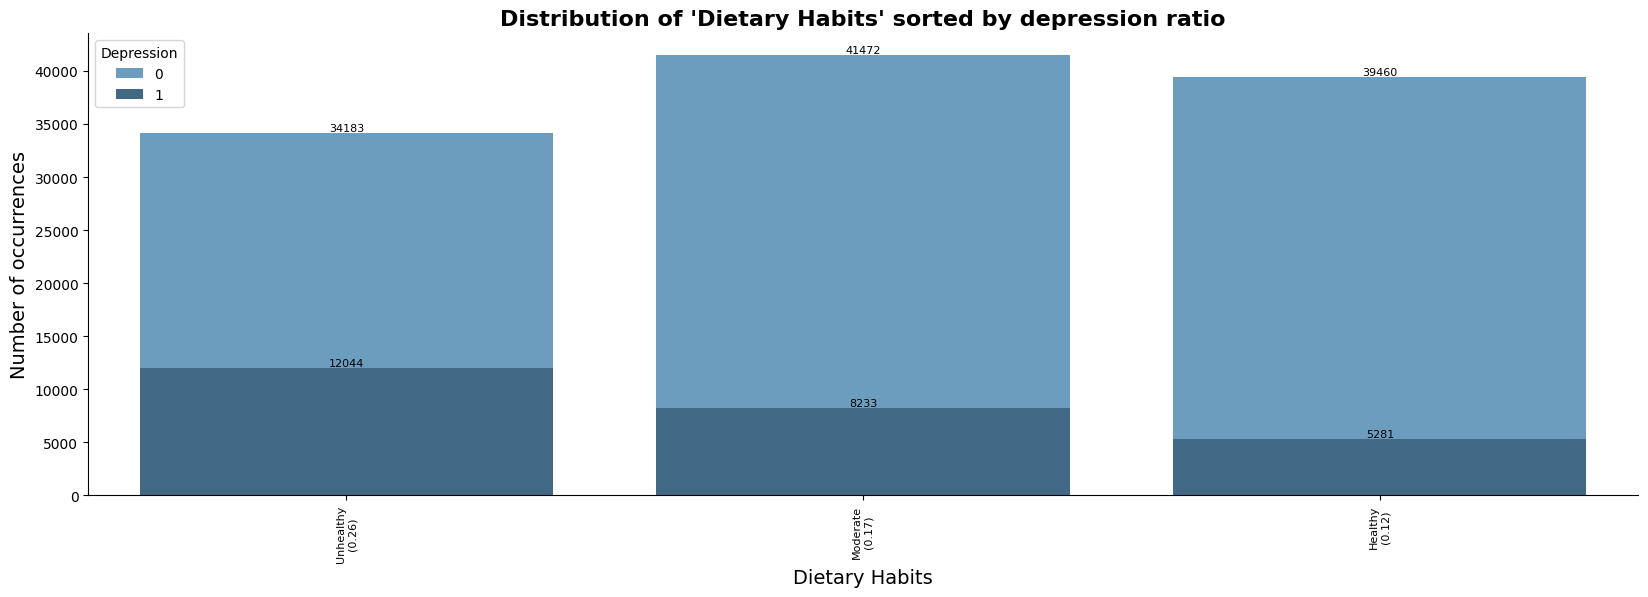

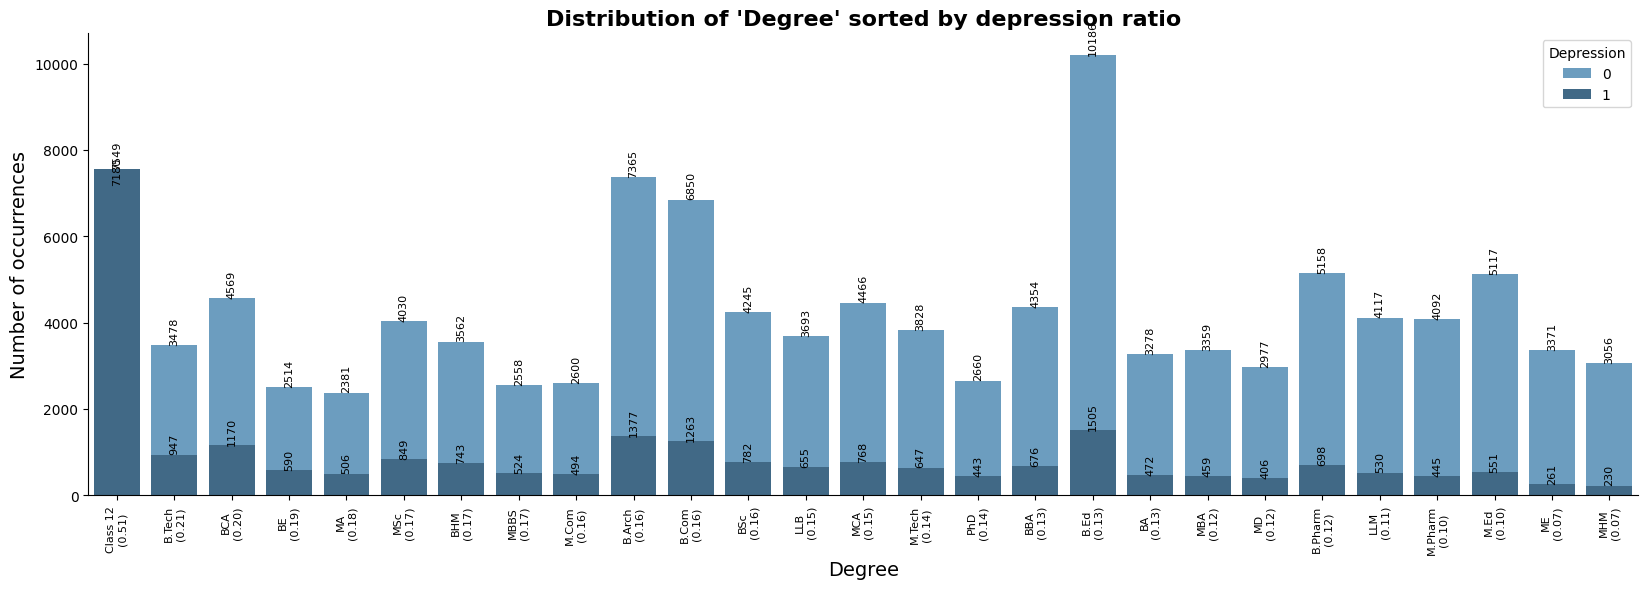

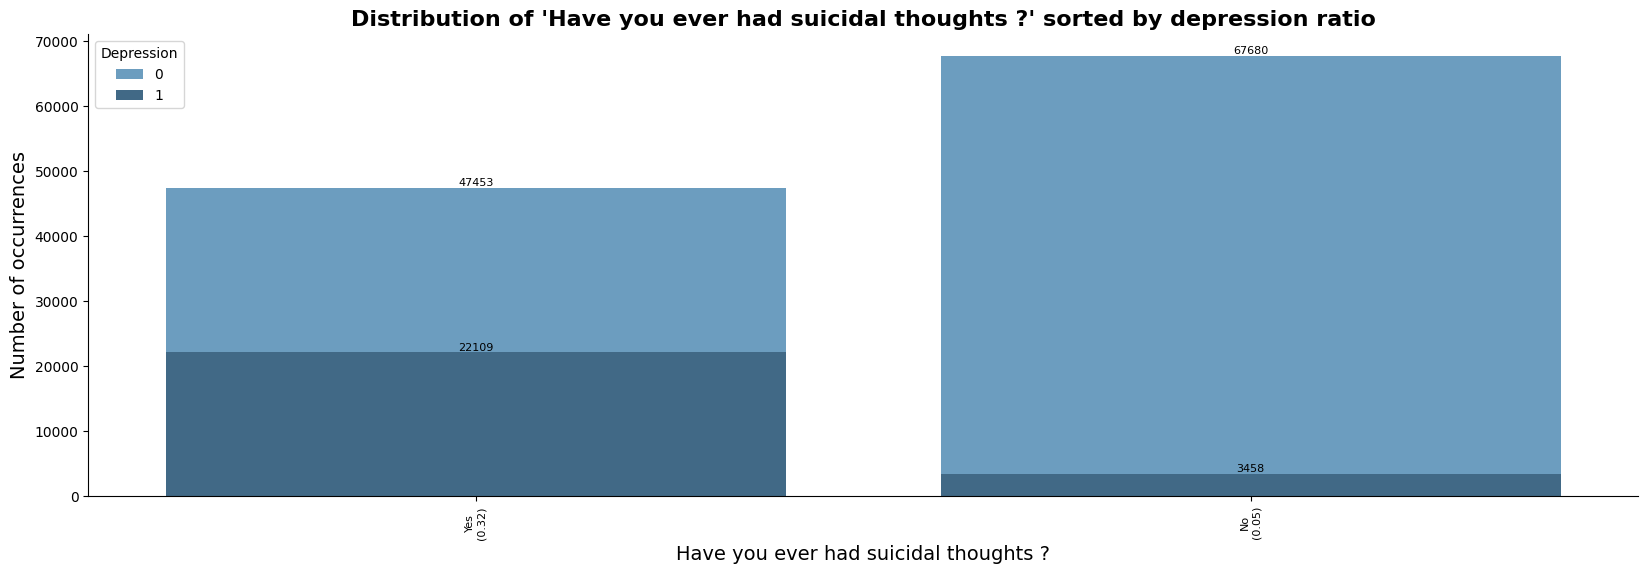

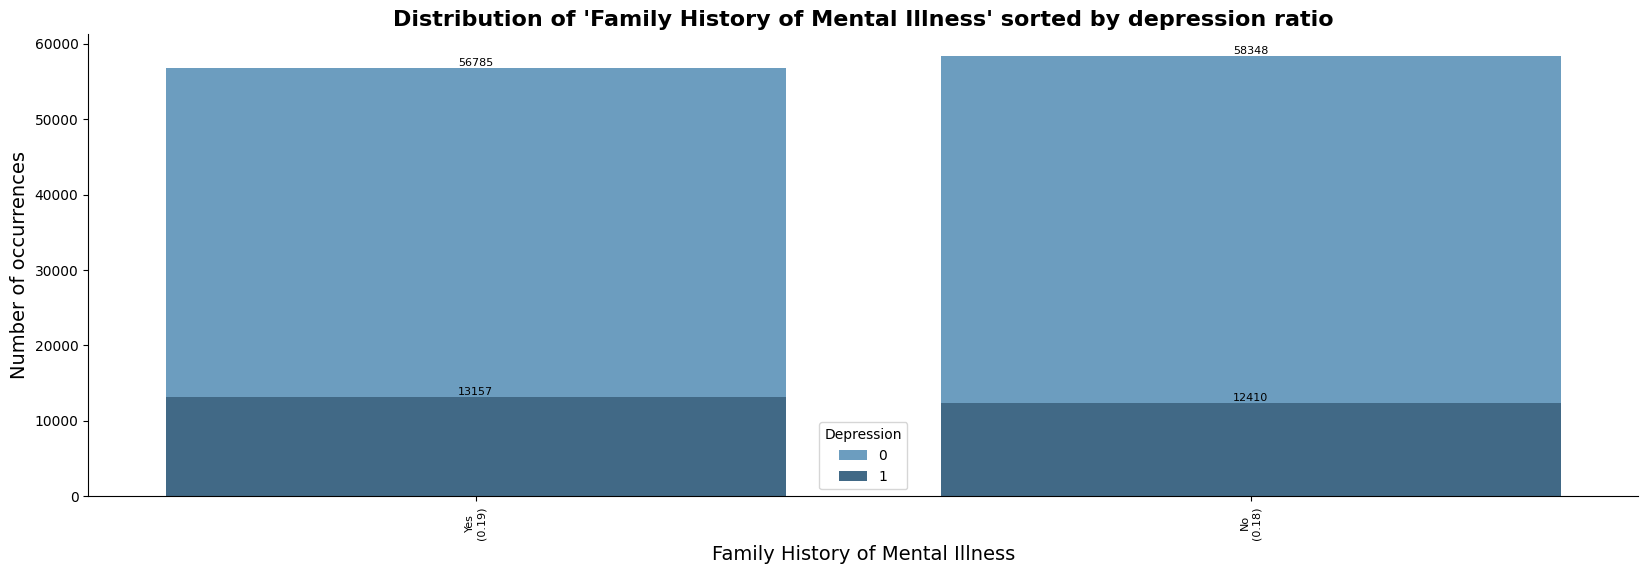

In [48]:
# Loop through each object type column
for col in object_columns:
    # Calculate the occurrences for each category and depression state
    counts = factors_filtered.groupby([col, 'Depression']).size().reset_index(name='Count')
    
    # Calculate the totals for each category
    total_counts = counts.groupby(col)['Count'].sum()

    # Calculate the depression ratio (percentage of 'Depression=True')
    depression_counts = counts[counts['Depression'] == True].set_index(col)['Count']
    ratios = (depression_counts / total_counts).fillna(0).sort_values(ascending=False)

    # Order categories by the depression ratio in descending order
    order = ratios.index
    
    # Create a DataFrame with the ratios and formatted labels for each category
    counts['Ratio'] = counts[col].map(ratios)
    ratios_with_labels = [f"{cat}\n({ratio:.2f})" for cat, ratio in zip(ratios.index, ratios)]

    # Set the figure size
    plt.figure(figsize=(20, 6))

    # Create the stacked countplot for 'Depression' categories (True/False) stacked on top of each other
    ax = sns.barplot(
        x=col,
        y='Count',
        data=counts,
        hue='Depression',
        order=order,
        palette="Blues_d",
        dodge=False  # Stack the bars on top of each other
    )
    
    # Add a title and adjust axes labels
    ax.set_title(f"Distribution of '{col}' sorted by depression ratio", fontsize=16, fontweight='bold')
    ax.set_xlabel(col, fontsize=14)
    ax.set_xticklabels(ratios_with_labels, fontsize=10)
    ax.set_ylabel("Number of occurrences", fontsize=14)

    # Rotate the x-axis labels if needed to make them readable
    plt.xticks(rotation=90, fontsize=8)
    
    # Conditionally rotate annotations based on the number of bars (categories)
    for p in ax.patches:
        height = p.get_height()  # Get the height (count) of each bar
        if height > 0:
            # Check if there are more than 10 bars, if so rotate the annotation
            rotation_angle = 90 if len(order) > 10 else 0
            ax.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2, height),  # Position of annotation
                        ha='center', va='bottom', fontsize=8, rotation=rotation_angle)

    # Remove top and right borders for a cleaner look
    sns.despine()

    # Show the plot
    plt.show()

### Calculating and Adding 'Name' Frequency

In this step, we calculate the frequency of each unique value in the 'Name' column:

- **Counting Name Frequencies:** The `value_counts()` method is used to calculate how many times each unique 'Name' appears in the `factors_filtered` DataFrame.
- **Adding Frequency Column:** A new column, 'Name frequency', is added to the DataFrame. This column maps each 'Name' to its corresponding frequency using the `map()` function.
  
The resulting DataFrame now includes the frequency of each name, providing insight into how common each name is in the dataset.


In [49]:
# Calculate the frequency of appearance for each 'Name'
name_frequency = factors_filtered['Name'].value_counts()

# Add the 'name_frequency' column to the original DataFrame
factors_filtered['Name frequency'] = factors_filtered['Name'].map(name_frequency)

# Display the final DataFrame
factors_filtered

Name  Gender   Age           City Working Professional or Student  \
0       Aaradhya  Female  49.0       Ludhiana            Working Professional   
1          Vivan    Male  26.0       Varanasi            Working Professional   
2         Yuvraj    Male  33.0  Visakhapatnam                         Student   
3         Yuvraj    Male  22.0         Mumbai            Working Professional   
4           Rhea  Female  30.0         Kanpur            Working Professional   
...          ...     ...   ...            ...                             ...   
140695     Vidya  Female  18.0      Ahmedabad            Working Professional   
140696      Lata  Female  41.0      Hyderabad            Working Professional   
140697   Aanchal  Female  24.0        Kolkata            Working Professional   
140698    Prachi  Female  49.0       Srinagar            Working Professional   
140699       Sai    Male  27.0          Patna                         Student   

               Profession  Academic Pressure  Work Pressure  CGPA  \
0                    Chef                NaN            5.0   NaN   
1                 Teacher                NaN            4.0   NaN   
2                     NaN                5.0            NaN  8.97   
3                 Teacher                NaN            5.0   NaN   
4        Business Analyst                NaN            1.0   NaN   
...                   ...                ...            ...   ...   
140695                NaN                NaN            5.0   NaN   
140696     Content Writer                NaN            5.0   NaN   
140697  Marketing Manager                NaN            3.0   NaN   
140698            Plumber                NaN            5.0   NaN   
140699                NaN                4.0            NaN  9.24   

        Study Satisfaction  Job Satisfaction     Sleep Duration  \
0                      NaN               2.0  More than 8 hours   
1                      NaN               3.0  Less than 5 hours   
2                      2.0               NaN          5-6 hours   
3                      NaN               1.0  Less than 5 hours   
4                      NaN               1.0          5-6 hours   
...                    ...               ...                ...   
140695                 NaN               4.0          5-6 hours   
140696                 NaN               4.0          7-8 hours   
140697                 NaN               1.0  More than 8 hours   
140698                 NaN               2.0          5-6 hours   
140699                 1.0               NaN  Less than 5 hours   

       Dietary Habits    Degree Have you ever had suicidal thoughts ?  \
0             Healthy       BHM                                    No   
1           Unhealthy       LLB                                   Yes   
2             Healthy   B.Pharm                                   Yes   
3            Moderate       BBA                                   Yes   
4           Unhealthy       BBA                                   Yes   
...               ...       ...                                   ...   
140695      Unhealthy  Class 12                                    No   
140696       Moderate    B.Tech                                   Yes   
140697       Moderate     B.Com                                    No   
140698       Moderate        ME                                   Yes   
140699        Healthy       BCA                                   Yes   

        Work/Study Hours  Financial Stress Family History of Mental Illness  \
0                    1.0               2.0                               No   
1                    7.0               3.0                               No   
2                    3.0               1.0                               No   
3                   10.0               1.0                              Yes   
4                    9.0               4.0                              Yes   
...                  ...               ...            

### Mapping Categorical Values to Numeric Scores

In this step, we define custom mappings for the 'Dietary Habits' and 'Sleep Duration' columns to convert categorical values into numeric scores:

- **Dietary Habits Mapping:** The categories ('Unhealthy', 'Moderate', 'Healthy') are mapped to numeric values (1, 3, 5) based on their relative healthiness.
- **Sleep Duration Mapping:** The sleep categories ('Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours') are mapped to numeric values representing the average hours of sleep (4, 5.5, 7.5, 9).

These mapped values are then applied to the respective columns using the `map()` function, transforming categorical data into a numerical format that can be used for further analysis or modeling.


In [50]:
# Define a custom mapping
DietaryHabitsMapping = {'Unhealthy': 1, 'Moderate': 3, 'Healthy': 5}
SleepDurationMapping = {'Less than 5 hours':4, '5-6 hours':5.5, '7-8 hours':7.5, 'More than 8 hours':9}

# Map the values to integers
factors_filtered['Dietary Habits'] = factors_filtered['Dietary Habits'].map(DietaryHabitsMapping)
factors_filtered['Sleep Duration'] = factors_filtered['Sleep Duration'].map(SleepDurationMapping)

### Visualizing the Distribution of 'Dietary Habits' and 'Sleep Duration'

In this step, we create histograms to visualize the distribution of the 'Dietary Habits' and 'Sleep Duration' columns:

- **Subplots Creation:** A grid of two subplots is created for the two columns, 'Dietary Habits' and 'Sleep Duration'.
- **Histogram Plotting:** 
  - The number of bins is dynamically determined based on the number of unique values in each column.
  - Seaborn's `histplot()` function is used to plot the histograms with a KDE line overlay, helping visualize both the frequency and the smooth distribution of the data.
  - The KDE line is customized with an orange color and a linewidth of 2 for better visibility.
- **Customization:** 
  - Titles and axis labels are added for clarity.
  - Gridlines, ticks, and plot borders (spines) are removed for a cleaner look.

This visualization allows us to examine the frequency and distribution of the 'Dietary Habits' and 'Sleep Duration' variables in the dataset.


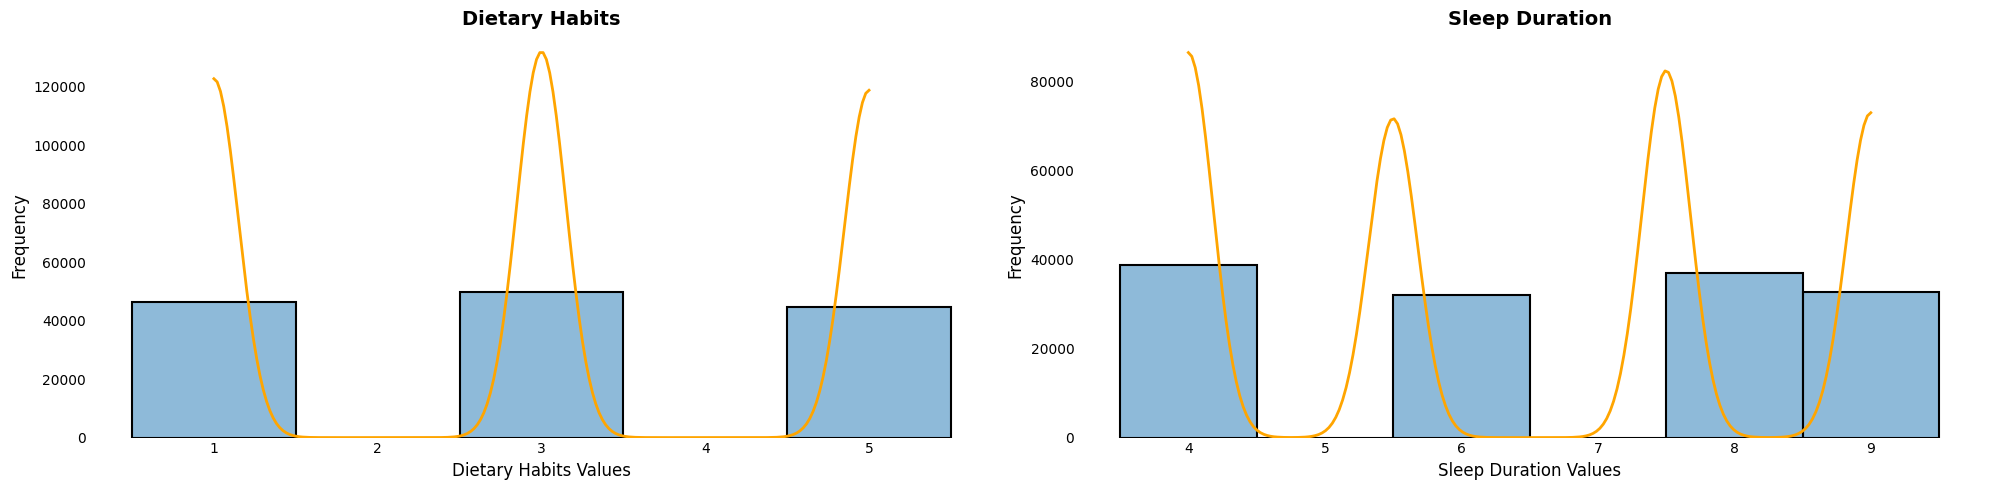

In [51]:
# Columns to plot
cols = ["Dietary Habits", "Sleep Duration"]

# Create the grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))  # Adjust the size as per your preference
axes = axes.flatten()  # Flatten the axes array to make it easier to iterate

# Plot a histogram for each column with customized styling
for ax, col in zip(axes, cols):
    # Calculate the number of bins based on the number of unique values
    bins = len(factors_filtered[col].unique())  # Set bins equal to the number of unique values

    # Plot the histogram with Seaborn's histplot (with KDE line)
    sns.histplot(factors_filtered[col], bins=bins, ax=ax, kde=True, edgecolor="black", 
                 linewidth=1.5, discrete=True)

    # Get the current axes and the lines from the KDE plot
    for line in ax.lines:
        if isinstance(line, plt.Line2D):  # Ensure it is a Line2D object (KDE line)
            line.set_color('orange')  # Set KDE line color
            line.set_linewidth(2)  # Set KDE line width

    # Set the title and labels for a cleaner look
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{col} Values', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Remove grid and ticks for a cleaner look
    ax.grid(False)  # Disable gridlines
    ax.tick_params(axis='both', which='both', length=0)  # Remove ticks
    
    # Remove the frame (spines) around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


## Handling Numeric Attributes


### Creating New Columns and Dropping Unnecessary Ones

In this step, new columns are created by taking the maximum value between two existing columns:

- **New Columns:**
  - **Pressure:** The maximum value between 'Academic Pressure' and 'Work Pressure' is calculated for each row.
  - **Satisfaction:** The maximum value between 'Study Satisfaction' and 'Job Satisfaction' is calculated for each row.

- **Dropping Unnecessary Columns:** The original columns that contributed to the new columns ('Name', 'CGPA', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction') are dropped as they are no longer needed.

The result is an updated DataFrame with the newly created columns and without the redundant ones.


In [52]:
# Create new columns by taking the maximum value between two columns
factors_filtered['Pressure'] = factors_filtered[['Academic Pressure', 'Work Pressure']].max(axis=1)
factors_filtered['Satisfaction'] = factors_filtered[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)

# Drop the original columns that are no longer needed
factors_filtered = factors_filtered.drop(
    ["Name", "CGPA", "Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction"], axis=1
)

# Display the updated DataFrame
factors_filtered.head()

Gender   Age           City Working Professional or Student  \
0  Female  49.0       Ludhiana            Working Professional   
1    Male  26.0       Varanasi            Working Professional   
2    Male  33.0  Visakhapatnam                         Student   
3    Male  22.0         Mumbai            Working Professional   
4  Female  30.0         Kanpur            Working Professional   

         Profession  Sleep Duration  Dietary Habits   Degree  \
0              Chef             9.0             5.0      BHM   
1           Teacher             4.0             1.0      LLB   
2               NaN             5.5             5.0  B.Pharm   
3           Teacher             4.0             3.0      BBA   
4  Business Analyst             5.5             1.0      BBA   

  Have you ever had suicidal thoughts ?  Work/Study Hours  Financial Stress  \
0                                    No               1.0               2.0   
1                                   Yes               7.0               3.0   
2                                   Yes               3.0               1.0   
3                                   Yes              10.0               1.0   
4                                   Yes               9.0               4.0   

  Family History of Mental Illness  Depression  Name frequency  Pressure  \
0                               No           0          2045.0       5.0   
1                               No           1           963.0       4.0   
2                               No           1           730.0       5.0   
3                              Yes           1           730.0       5.0   
4                              Yes           0           499.0       1.0   

   Satisfaction  
0           2.0  
1           3.0  
2           2.0  
3           1.0  
4           1.0

### Handling Missing Values with Median Imputation

In this step, missing values in the numerical columns of the dataset are handled using median imputation:

- **Selecting Numerical Columns:** Only the numerical columns are selected from the `factors_filtered` DataFrame using `select_dtypes()`.
- **Median Imputation:**
  - The `SimpleImputer` is initialized with the "median" strategy, meaning that missing values will be replaced with the median of each column.
  - The imputer is fitted to the numerical data using `fit()` and then applied to transform the data with `transform()`.
- **Creating the Imputed DataFrame:** The transformed data is stored in a new DataFrame (`factors_tr`) with the same column names and index as the original data, retaining the structure.

The result is a new DataFrame where missing values are imputed with the median of the respective columns.


In [53]:
# Select only the numerical columns from the DataFrame
factors_num = factors_filtered.select_dtypes(include=[np.number])

# Initialize the SimpleImputer with median strategy
imputer = SimpleImputer(strategy="median")

# Fit the imputer on the numerical data and transform it to handle missing values
imputer.fit(factors_num)
X = imputer.transform(factors_num)

# Create a new DataFrame with the imputed values, retaining the original columns and index
factors_tr = pd.DataFrame(X, columns=factors_num.columns, index=factors_num.index)

# Display the imputed DataFrame (optional)
factors_tr.head()

Age  Sleep Duration  Dietary Habits  Work/Study Hours  Financial Stress  \
0  49.0             9.0             5.0               1.0               2.0   
1  26.0             4.0             1.0               7.0               3.0   
2  33.0             5.5             5.0               3.0               1.0   
3  22.0             4.0             3.0              10.0               1.0   
4  30.0             5.5             1.0               9.0               4.0   

   Depression  Name frequency  Pressure  Satisfaction  
0         0.0          2045.0       5.0           2.0  
1         1.0           963.0       4.0           3.0  
2         1.0           730.0       5.0           2.0  
3         1.0           730.0       5.0           1.0  
4         0.0           499.0       1.0           1.0

## Calculating the 'Health Profile' Metric

In this step, a new feature, **'Health Profile'**, is calculated based on a custom formula that combines several existing columns:

- **Formula for 'Health Profile':**
  \[
  \text{{Health Profile}} = \frac{{\text{{Financial Stress}} \times \text{{Pressure}} \times (\text{{Work/Study Hours}} + 1)}}{{\text{{Sleep Duration}} \times \text{{Dietary Habits}} \times \text{{Satisfaction}} \times (\text{{Age}}^4)}}
  \]
  - The **numerator** includes: 
    - 'Financial Stress' 
    - 'Pressure' 
    - ('Work/Study Hours' + 1)
  - The **denominator** includes: 
    - 'Sleep Duration'
    - 'Dietary Habits'
    - 'Satisfaction'
    - 'Age' raised to the power of 4.

- **Handling Potential Issues:** 
  - To avoid division by zero, small constants (e.g., `1e-10`) are added to the denominator for each term that could potentially be zero, ensuring that the formula works even when certain values are missing or zero.

The result is a new column, **'Health Profile'**, which represents a composite score summarizing various aspects of an individual's health and lifestyle.
alth profile.


In [54]:
factors_tr["Health Profile"] = (factors_tr["Financial Stress"]*(factors_tr["Pressure"])*(factors_tr["Work/Study Hours"]+1)) / \
    (factors_tr["Sleep Duration"]*factors_tr["Dietary Habits"]*factors_tr["Satisfaction"]*(factors_tr["Age"]**4))


### Visualizing the Distribution of the 'Health Profile'

In this step, we create a **Kernel Density Estimate (KDE)** plot to visualize the distribution of the **'Health Profile'**:

- **KDE Plot:** 
  - We use Seaborn's `kdeplot()` to create a smooth density plot, which provides an estimate of the probability density function of the 'Health Profile' values.
  - The plot is filled with a semi-transparent color (`alpha=0.6`), and the KDE line has a thickness of 2 for better visibility.

- **Customization:** 
  - A title and axis labels are added for clarity, specifying that the plot shows the distribution of the 'Health Profile'.
  - The figure size is adjusted to provide a clear and readable view of the distribution.

This plot gives a visual representation of how the 'Health Profile' scores are distributed, helping to understand patterns in the data.


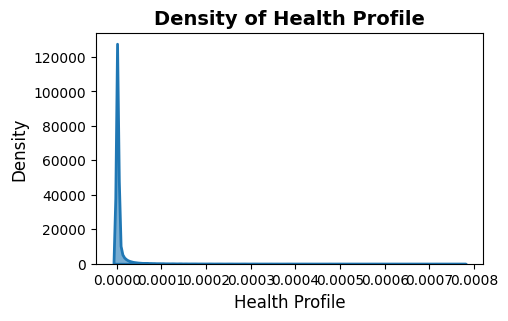

In [55]:
# Create the density plot for "Health Profile"
plt.figure(figsize=(5, 3))

# Plot the KDE with some styling options
sns.kdeplot(data=factors_tr, x="Health Profile", fill=True, alpha=0.6, linewidth=2)

# Add labels and a title
plt.title("Density of Health Profile", fontsize=14, fontweight='bold')
plt.xlabel("Health Profile", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Show the plot
plt.show()

### Handling Inf Values and Applying Log Transformation to 'Health Profile'

In this step, two transformations are applied to the **'Health Profile'** column:

1. **Replacing Infinite Values with Zero:**
   - The `apply()` function is used along with `np.isinf()` to check for infinite values in the 'Health Profile' column. Any infinite values (positive or negative) are replaced with zero.
   - Additionally, values less than or equal to zero are also replaced with zero to prevent issues with the subsequent log transformation.

2. **Log Transformation:**
   - A natural logarithm transformation (`np.log()`) is applied to the 'Health Profile' column. This transformation helps in normalizing the data and reducing the impact of extreme values.

The result is an updated 'Health Profile' column with transformed values, making it more suitable for modeling and analysis.


In [56]:
# Replace inf values with 0
factors_tr["Health Profile"] = factors_tr["Health Profile"].apply(lambda x: 0 if np.isinf(x) or x <= 0 else x)

# Apply log transformation
factors_tr["Health Profile"] = np.log(factors_tr["Health Profile"])

# Check the result
factors_tr.head()

Age  Sleep Duration  Dietary Habits  Work/Study Hours  Financial Stress  \
0  49.0             9.0             5.0               1.0               2.0   
1  26.0             4.0             1.0               7.0               3.0   
2  33.0             5.5             5.0               3.0               1.0   
3  22.0             4.0             3.0              10.0               1.0   
4  30.0             5.5             1.0               9.0               4.0   

   Depression  Name frequency  Pressure  Satisfaction  Health Profile  
0         0.0          2045.0       5.0           2.0      -17.071359  
1         1.0           963.0       4.0           3.0      -10.952945  
2         1.0           730.0       5.0           2.0      -14.997631  
3         1.0           730.0       5.0           1.0      -10.841743  
4         0.0           499.0       1.0           1.0      -11.620658

### Visualizing the Distribution of 'Health Profile' by 'Depression' Levels

In this step, we create a **Kernel Density Estimate (KDE)** plot to visualize the distribution of the **'Health Profile'** values, separated by the 'Depression' status:

- **KDE Plot with Hue:**
  - The `hue="Depression"` argument is used to differentiate the density plots based on the 'Depression' column, allowing us to visualize how the 'Health Profile' distribution differs between individuals with and without depression.
  - The plot is filled with a semi-transparent color (`alpha=0.6`) to highlight the density, and separate density curves are plotted for each 'Depression' group.

- **Customization:** 
  - A title and axis labels are added to clarify the content of the plot.
  - The figure size is set to ensure clarity and readability.

This plot provides insights into how the 'Health Profile' distribution varies between individuals with and without depression.


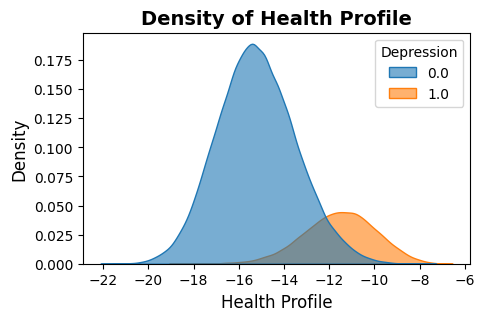

In [57]:
# Create the density plot for "Health Profile" with separation by "Depression"
plt.figure(figsize=(5, 3))

# Plot the KDE with hue for "Depression"
sns.kdeplot(data=factors_tr, x="Health Profile", hue="Depression", fill=True, alpha=0.6)

# Add title and labels
plt.title("Density of Health Profile", fontsize=14, fontweight='bold')
plt.xlabel("Health Profile", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Show the plot
plt.show()


### Creating New Columns Based on Existing Variables

In this step, several new features are created by combining existing columns:

1. **'Pressure Sleep Duration ratio':** 
   - This column is calculated by dividing the 'Pressure' by 'Sleep Duration', representing the relationship between pressure and sleep duration.

2. **'Work/Study Hours * Pressure':**
   - This new column is created by multiplying 'Work/Study Hours' by 'Pressure', capturing the combined effect of work/study hours and pressure.

3. **'Work/Study Hours Satisfaction ratio':**
   - This column represents the ratio of 'Work/Study Hours' to 'Satisfaction', providing a measure of how work/study hours relate to overall satisfaction.

The updated DataFrame now includes these new columns, offering additional insights into the relationships between different variables.


In [58]:
# Creating new columns based on existing columns
factors_tr["Pressure Sleep Duration ratio"] = factors_tr["Pressure"] / factors_tr["Sleep Duration"]
factors_tr["Work/Study Hours * Pressure"] = factors_tr["Work/Study Hours"] * factors_tr["Pressure"]
factors_tr["Work/Study Hours Satisfaction ratio"] = factors_tr["Work/Study Hours"] / factors_tr["Satisfaction"]

# Check the updated DataFrame
factors_tr.head()

Age  Sleep Duration  Dietary Habits  Work/Study Hours  Financial Stress  \
0  49.0             9.0             5.0               1.0               2.0   
1  26.0             4.0             1.0               7.0               3.0   
2  33.0             5.5             5.0               3.0               1.0   
3  22.0             4.0             3.0              10.0               1.0   
4  30.0             5.5             1.0               9.0               4.0   

   Depression  Name frequency  Pressure  Satisfaction  Health Profile  \
0         0.0          2045.0       5.0           2.0      -17.071359   
1         1.0           963.0       4.0           3.0      -10.952945   
2         1.0           730.0       5.0           2.0      -14.997631   
3         1.0           730.0       5.0           1.0      -10.841743   
4         0.0           499.0       1.0           1.0      -11.620658   

   Pressure Sleep Duration ratio  Work/Study Hours * Pressure  \
0                       0.555556                          5.0   
1                       1.000000                         28.0   
2                       0.909091                         15.0   
3                       1.250000                         50.0   
4                       0.181818                          9.0   

   Work/Study Hours Satisfaction ratio  
0                             0.500000  
1                             2.333333  
2                             1.500000  
3                            10.000000  
4                             9.000000

### Generating a Correlation Heatmap

In this step, a correlation matrix is computed and visualized as a heatmap to explore the relationships between numerical variables, particularly in relation to 'Depression':

1. **Correlation Matrix:**
   - The `corr()` function is used to calculate the pairwise correlations between numeric columns in the `factors_tr` DataFrame. The result is rounded to two decimal places for clarity.

2. **Sorting Correlations with 'Depression':**
   - The correlations of all variables with 'Depression' are extracted and sorted in descending order to highlight the strongest relationships.

3. **Heatmap Creation:**
   - A heatmap is generated using Seaborn's `heatmap()` function, with a custom colormap ('BrBG') to visually represent the correlation values.
   - The upper triangle of the heatmap is masked to avoid redundant values (since the matrix is symmetrical).
   - Annotations are added to display the exact correlation values.

4. **Customization:**
   - The title of the heatmap is adjusted for clarity, ensuring it is positioned well above the plot.

This heatmap visually summarizes the correlations between variables and provides insights into how features are related to 'Depression'.


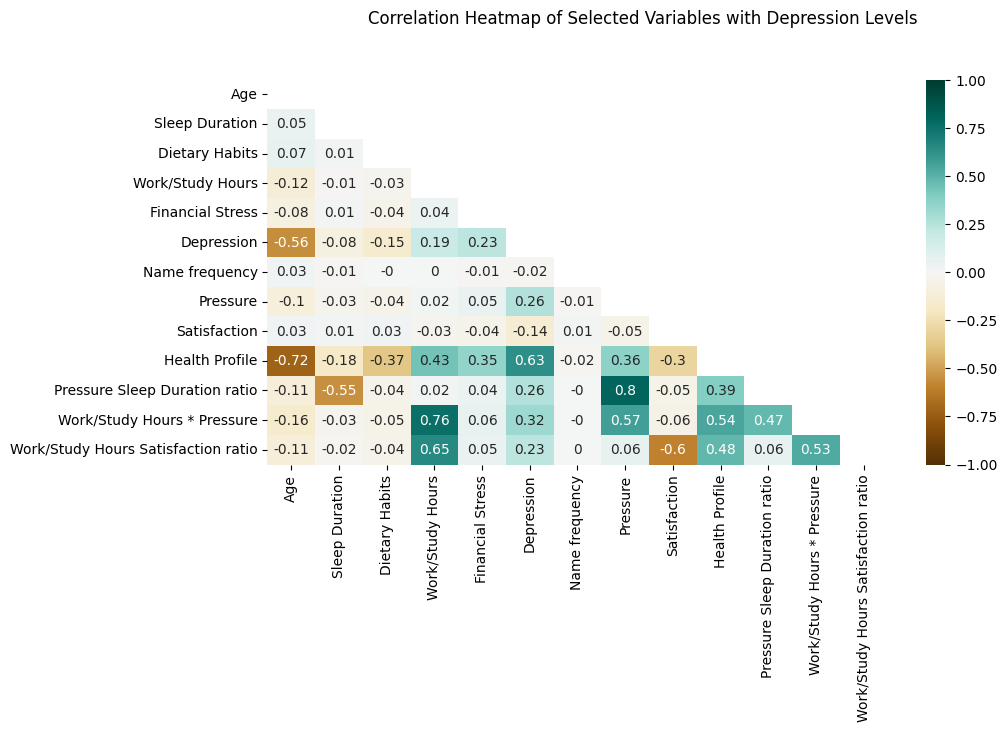

In [59]:
# Calculate the correlation matrix and round to 2 decimal places
corr_matrix = factors_tr.corr(numeric_only=True).round(2)

# Sort correlations of "Depression" in descending order
corr_with_depression = corr_matrix["Depression"].sort_values(ascending=False)

# Create the correlation heatmap
plt.figure(figsize=(10, 5))

# Mask the upper triangle of the heatmap (to avoid redundant values)
mask = np.triu(np.ones_like(corr_matrix))

# Create the heatmap with the selected colormap and annotations
sns.heatmap(corr_matrix, cmap='BrBG', mask=mask, vmin=-1, vmax=1, annot=True)

# Add title
plt.suptitle("Correlation Heatmap of Selected Variables with Depression Levels", y=1.02)  # Adjust y for spacing

# Show the plot
plt.show()


The "Health Profile" variable is the most correlated with the target, but it turns out that it degrades the performance of classification models during training. I will not keep it.

## Feature Scaling

### Standardizing the Data

In this step, we standardize the features in the `factors_tr` DataFrame using **StandardScaler**:

1. **Initializing StandardScaler:**
   - The `StandardScaler()` is initialized to scale the features such that they have a mean of 0 and a standard deviation of 1.

2. **Scaling the Features:**
   - The `fit_transform()` method is applied to the entire `factors_tr` DataFrame, which both fits the scaler to the data and transforms the data to a standardized scale.

3. **Creating the Standardized DataFrame:**
   - The scaled data is then converted back to a DataFrame (`factors_std`) with the same columns and index as the original data, allowing for easier manipulation and comparison.

The result is a new DataFrame where all numerical features have been standardized, making them suitable for models that are sensitive to feature scaling.


In [60]:
# Initialize the StandardScaler
std_scaler = StandardScaler()

# Apply the fit_transform method to scale the features in factors_tr
X = std_scaler.fit_transform(factors_tr)

# Convert the scaled data back to a DataFrame
factors_std = pd.DataFrame(X, columns=factors_tr.columns, index=factors_tr.index)

# Display the standardized DataFrame
factors_std.head()

Age  Sleep Duration  Dietary Habits  Work/Study Hours  \
0  0.695360        1.344878        1.256906         -1.363057   
1 -1.161867       -1.267657       -1.230634          0.193928   
2 -0.596624       -0.483896        1.256906         -0.844062   
3 -1.484863       -1.267657        0.013136          0.972421   
4 -0.838871       -0.483896       -1.230634          0.712923   

   Financial Stress  Depression  Name frequency  Pressure  Satisfaction  \
0         -0.699617   -0.471238        1.743350  1.407149     -0.689303   
1          0.007793    2.122072       -0.045294  0.693800      0.022367   
2         -1.407027    2.122072       -0.430464  1.407149     -0.689303   
3         -1.407027    2.122072       -0.430464  1.407149     -1.400973   
4          0.715203   -0.471238       -0.812328 -1.446249     -1.400973   

   Health Profile  Pressure Sleep Duration ratio  Work/Study Hours * Pressure  \
0       -1.131404                       0.113001                    -0.889415   
1        1.614377                       1.568171                     0.567609   
2       -0.200771                       1.270522                    -0.255926   
3        1.664281                       2.386703                     1.961285   
4        1.314725                      -1.110664                    -0.636020   

   Work/Study Hours Satisfaction ratio  
0                            -0.853845  
1                            -0.204088  
2                            -0.499432  
3                             2.513080  
4                             2.158667

### Mapping Categorical Variables to Binary Values

In this step, two categorical variables are mapped to binary values:

1. **'Suicidal Thoughts' Mapping:**
   - The column **'Have you ever had suicidal thoughts ?'** is mapped to binary values:
     - "Yes" is mapped to 1
     - "No" is mapped to 0
   - The new binary column is named **'Suicidal thoughts'**.

2. **'Family History' Mapping:**
   - The column **'Family History of Mental Illness'** is similarly mapped to binary values:
     - "Yes" is mapped to 1
     - "No" is mapped to 0
   - The new binary column is named **'Family History'**.

3. **Dropping Original Columns:**
   - The original categorical columns that have been replaced with the binary mappings are dropped from the DataFrame, including:
     - 'Working Professional or Student'
     - 'Have you ever had suicidal thoughts ?'
     - 'Family History of Mental Illness'

The result is a cleaner DataFrame with binary columns representing 'Suicidal thoughts' and 'Family History'.


In [61]:
# Map categorical variables to binary values
factors_filtered["Suicidal thoughts"] = factors_filtered["Have you ever had suicidal thoughts ?"].map({"Yes": 1, "No": 0})
factors_filtered["Family History"] = factors_filtered["Family History of Mental Illness"].map({"Yes": 1, "No": 0})

# Drop the original columns that are no longer needed
factors_filtered = factors_filtered.drop(
    ["Working Professional or Student", "Have you ever had suicidal thoughts ?", "Family History of Mental Illness"], axis=1
)

# Display the updated DataFrame
factors_filtered.head()

Gender   Age           City        Profession  Sleep Duration  \
0  Female  49.0       Ludhiana              Chef             9.0   
1    Male  26.0       Varanasi           Teacher             4.0   
2    Male  33.0  Visakhapatnam               NaN             5.5   
3    Male  22.0         Mumbai           Teacher             4.0   
4  Female  30.0         Kanpur  Business Analyst             5.5   

   Dietary Habits   Degree  Work/Study Hours  Financial Stress  Depression  \
0             5.0      BHM               1.0               2.0           0   
1             1.0      LLB               7.0               3.0           1   
2             5.0  B.Pharm               3.0               1.0           1   
3             3.0      BBA              10.0               1.0           1   
4             1.0      BBA               9.0               4.0           0   

   Name frequency  Pressure  Satisfaction  Suicidal thoughts  Family History  
0          2045.0       5.0           2.0                  0               0  
1           963.0       4.0           3.0                  1               0  
2           730.0       5.0           2.0                  1               0  
3           730.0       5.0           1.0                  1               1  
4           499.0       1.0           1.0                  1               1

### One-Hot Encoding Categorical Variables

In this step, categorical variables are transformed into a one-hot encoded format to make them suitable for machine learning models:

1. **Initializing OneHotEncoder:**
   - The `OneHotEncoder()` from Scikit-learn is used with the following parameters:
     - `sparse_output=False`: Returns a dense array instead of a sparse matrix.
     - `drop='first'`: Drops the first category of each feature to avoid the dummy variable trap (multicollinearity).

2. **Selecting Categorical Columns:**
   - The categorical columns are selected using `select_dtypes(include=["object"])`, which filters columns with object data types.

3. **Applying One-Hot Encoding:**
   - The `fit_transform()` method is applied to the selected categorical columns, transforming them into a one-hot encoded format.

4. **Creating a One-Hot Encoded DataFrame:**
   - The one-hot encoded data is converted into a DataFrame with appropriate column names derived from the encoder's feature names.
   - The new DataFrame maintains the original index for consistency.

5. **Concatenating the Encoded Data with the Original Data:**
   - The one-hot encoded columns are concatenated with the original DataFrame, excluding the original categorical columns, to create a final DataFrame (`factors_filtered_final`).

The result is a DataFrame with categorical variables replaced by their one-hot encoded representations, making it ready for machine learning models.


In [62]:
# Initialize the OneHotEncoder
cat_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid the dummy variable trap

# Select the categorical columns
factors_cat = factors_filtered.select_dtypes(include=["object"])

# Apply one-hot encoding
factors_filtered_1hot = cat_encoder.fit_transform(factors_cat)

# Convert the one-hot encoded data into a DataFrame
factors_filtered_1hot_df = pd.DataFrame(factors_filtered_1hot, 
                                        columns=cat_encoder.get_feature_names_out(factors_cat.columns),
                                        index=factors_cat.index)

# Concatenate the one-hot encoded DataFrame with the original DataFrame (excluding original categorical columns)
factors_filtered_final = pd.concat([factors_filtered.drop(factors_cat.columns, axis=1), factors_filtered_1hot_df], axis=1)

# Display the final DataFrame
factors_filtered_final.head()

Age  Sleep Duration  Dietary Habits  Work/Study Hours  Financial Stress  \
0  49.0             9.0             5.0               1.0               2.0   
1  26.0             4.0             1.0               7.0               3.0   
2  33.0             5.5             5.0               3.0               1.0   
3  22.0             4.0             3.0              10.0               1.0   
4  30.0             5.5             1.0               9.0               4.0   

   Depression  Name frequency  Pressure  Satisfaction  Suicidal thoughts  ...  \
0           0          2045.0       5.0           2.0                  0  ...   
1           1           963.0       4.0           3.0                  1  ...   
2           1           730.0       5.0           2.0                  1  ...   
3           1           730.0       5.0           1.0                  1  ...   
4           0           499.0       1.0           1.0                  1  ...   

   Degree_MA  Degree_MBA  Degree_MBBS  Degree_MCA  Degree_MD  Degree_ME  \
0        0.0         0.0          0.0         0.0        0.0        0.0   
1        0.0         0.0          0.0         0.0        0.0        0.0   
2        0.0         0.0          0.0         0.0        0.0        0.0   
3        0.0         0.0          0.0         0.0        0.0        0.0   
4        0.0         0.0          0.0         0.0        0.0        0.0   

   Degree_MHM  Degree_MSc  Degree_PhD  Degree_nan  
0         0.0         0.0         0.0         0.0  
1         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0  

[5 rows x 104 columns]

## Creation of a train set and a validation set

### Stratified Split of Data Based on Age

In this step, the dataset is split into **training** and **validation** sets while ensuring that the age distribution is preserved in both sets:

1. **Stratification Based on Age:**
   - A new temporary column **'Age_cat'** is created to categorize the 'Age' variable into 8 bins using `pd.cut()`. The bins are defined as follows:
     - [0, 25], [25, 30], [30, 35], [35, 40], [40, 45], [45, 50], [50, 55], [55, ∞]
   - These bins are labeled with numeric values (1 to 8) to represent different age groups.

2. **Train-Test Split with Stratification:**
   - The `train_test_split()` function is used to split the data into a training set (80%) and a validation set (20%), while maintaining the same distribution of age categories across both sets. The `stratify` parameter ensures that the split is done in a way that preserves the proportion of each age category in both sets.

3. **Dropping the Temporary 'Age_cat' Column:**
   - The **'Age_cat'** column is dropped from both the training and validation sets as it is no longer needed after the split.

4. **Separating Features and Target:**
   - In both the training and validation sets, the target column (e.g., **'Depression'**) is separated from the features. The target column is stored in `y_train` and `y_validation`, while the remaining features are stored in `X_train` and `X_validation`.

This function returns the training and validation datasets, ready for modeling, while ensuring the age distribution is balaced in both sets.


In [63]:
# Function to stratify the data based on age and then split it into training and validation sets
def stratify_and_split(data, target_column):
    # Create a temporary 'Age_cat' column for stratification based on 'Age'
    # Using pd.cut to categorize 'Age' into 8 different bins
    data["Age_cat"] = pd.cut(data["Age"],
                             bins=[0, 25, 30, 35, 40, 45, 50, 55, np.inf],
                             labels=[1, 2, 3, 4, 5, 6, 7, 8])  # Labels are numeric to represent different age groups
    
    # Split into training and validation sets
    # We use stratification to ensure the distribution of 'Age_cat' is preserved in both sets
    train_set, validation_set = train_test_split(
        data, test_size=0.1, stratify=data["Age_cat"], random_state=42)
    # stratify=data["Age_cat"] ensures that both the train and validation sets have similar age distributions
    
    # Drop the 'Age_cat' column from both the training and validation sets
    train_set = train_set.drop(columns=["Age_cat"])
    validation_set = validation_set.drop(columns=["Age_cat"])
    
    # Separate the target variable from features in the training set
    y_train = train_set[target_column]  # Extract the target column (e.g., 'Depression')
    X_train = train_set.drop(columns=[target_column])  # Drop the target column to get the features
    
    # For the validation set, do the same
    y_validation = validation_set[target_column]  # Extract the target column (e.g., 'Depression')
    X_validation = validation_set.drop(columns=[target_column])  # Drop the target column to get the features
    
    # Return the training and validation datasets
    return X_train, X_validation, y_train, y_validation

### Splitting the Data into Training and Validation Sets

In this step, the data is split into **training** and **validation** sets using the previously defined `stratify_and_split()` function:

1. **Creating a Copy of the Data:**
   - A copy of the `data` DataFrame is created and stored in `train_set` to avoid modifying the original dataset.

2. **Stratified Split:**
   - The `stratify_and_split()` function is called to perform a stratified split based on the 'Depression' target column. This ensures that the distribution of the target variable is preserved in both the training and validation sets.

3. **Separation of Features and Target:**
   - The function returns:
     - `X_train`: Features for the training set.
     - `X_val`: Features for the validation set.
     - `y_train`: Target variable for the training set (e.g., 'Depression').
     - `y_val`: Target variable for the validation set.

This split ensures that both training and validation datasets are representative of the target variable's distribution, allowing for a more reliable model evaluation.


In [64]:
train_set = data.copy()

# Séparation des données
X_train, X_val, y_train, y_val = stratify_and_split(train_set, 'Depression')

## Pipelining

### Creating Custom Transformers and Preprocessing Pipelines

In this step, custom transformers and pipelines are defined for preprocessing the dataset:

1. **Custom Transformers:**
   - **FrequentCategoryFilter:** A transformer that filters out infrequent categories in categorical columns based on a specified minimum count.
   - **FrequencyEncoder:** Encodes the 'Name' column by adding a frequency count for each unique value.
   - **DropColumns:** Drops specified columns from the DataFrame.
   - **ProfessionTransformer:** Modifies the 'Profession' column based on the 'Working Professional or Student' column.
   - **PressureSatisfactionTransformer:** Creates new columns for 'Pressure' and 'Satisfaction' by taking the maximum of 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', and 'Job Satisfaction'.
   - **AddOneToHours:** Adds 1 to the 'Work/Study Hours' column for transformation purposes.
   - **CustomMappingTransformer:** Applies custom mappings to specified columns, such as mapping 'Dietary Habits' and 'Sleep Duration' to numeric values.

2. **Function Transformers:**
   - **column_ratio:** Computes the ratio between two columns.
   - **column_product:** Computes the product of two columns.
   - **column_custom:** Computes a custom transformation using multiple columns, such as calculating a 'Health Profile' score.

3. **Pipelines for Feature Transformation:**
   - **ratio_pipeline:** A pipeline that computes a ratio between two columns, imputes missing values, and scales the result.
   - **product_pipeline:** A pipeline that computes the product of two columns, imputes missing values, and scales the result.
   - **custom_pipeline:** A pipeline that applies a custom formula to a set of columns, imputes missing values, and scales the result.

4. **Categorical Data Pipeline:**
   - **cat_pipeline:** A pipeline that imputes missing categorical values with the most frequent value and applies one-hot encoding.

5. **Full Preprocessing Pipeline:**
   - **preprocessing:** A `ColumnTransformer` is used to apply different transformations to different columns, including the product, ratio, and custom transformations, as well as one-hot encoding for categorical variables.

6. **Final Pipeline:**
   - **pipeline:** Combines all preprocessing steps, including custom transformers, feature engineering, and the preprocessing pipeline. The final pipeline is ready to be used for model training and prediction.

This setup ensures that data is preprocessed effectively, with both numerical and categorical features being handled appropriately for machine learning models.


In [65]:
# Create a class to filter out infrequent categories
class FrequentCategoryFilter(BaseEstimator, TransformerMixin):
    def __init__(self, min_count=20):
        # Set the minimum count for categories to be considered frequent
        self.min_count = min_count
        self.frequent_values_ = {}  # Dictionary to store the frequent categories for each column

    def fit(self, X, y=None):
        # Identify frequent categories for each column
        for col in X.columns:
            value_counts = X[col].value_counts()  # Get value counts for the column
            frequent_values = value_counts[value_counts > self.min_count].index  # Filter values above min_count
            self.frequent_values_[col] = set(frequent_values)  # Store the frequent values for each column
        return self

    def transform(self, X):
        # Create a copy of the data to avoid modifying the original
        X = X.copy()
        for col in X.columns:
            # For each column, replace infrequent values with NaN
            if col in self.frequent_values_:
                X.loc[~X[col].isin(self.frequent_values_[col]), col] = np.nan
        return X


# Create a class to encode the 'Name' column based on frequency of occurrence
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting required for this encoder

    def transform(self, X):
        # Calculate the frequency of occurrence for each 'Name'
        name_frequency = X['Name'].value_counts()
        
        # Add a new column with the frequency of each 'Name'
        X['Name frequency'] = X['Name'].map(name_frequency)

        return X


# Create a class to drop specific columns from the DataFrame
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        # List of columns to drop
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self  # No fitting required for dropping columns

    def transform(self, X):
        # Drop the specified columns
        return X.drop(columns=self.columns_to_drop)


# Create a class to transform the 'Profession' column based on the 'Working Professional or Student' column
class ProfessionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting required for this transformation

    def transform(self, X):
        # Apply transformation to the 'Profession' column
        X['Profession'] = X.apply(lambda x: 'Student' if x['Working Professional or Student'] == 'Student' else x['Profession'], axis=1)
        return X


# Create a class to calculate the 'Pressure' and 'Satisfaction' columns
class PressureSatisfactionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting required for this calculation

    def transform(self, X):     
        # Calculate 'Pressure' as the maximum of 'Academic Pressure' and 'Work Pressure'
        X['Pressure'] = X[['Academic Pressure', 'Work Pressure']].max(axis=1)
        
        # Calculate 'Satisfaction' as the maximum of 'Study Satisfaction' and 'Job Satisfaction'
        X['Satisfaction'] = X[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
        return X


# Create a class to add 1 to the 'Work/Study Hours' column
class AddOneToHours(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting required for this transformation
    
    def transform(self, X):
        # Add 1 to the 'Work/Study Hours' column
        X['Work/Study Hours'] = X['Work/Study Hours'] + 1
        return X


# Create a class for custom mapping transformations
class CustomMappingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mappings):
        # Store the mappings provided
        self.mappings = mappings

    def fit(self, X, y=None):
        return self  # No fitting required for this transformation

    def transform(self, X):
        # Apply the mapping to the relevant columns in the DataFrame
        X = X.copy()
        for col, mapping in self.mappings.items():
            if col in X.columns:
                X[col] = X[col].map(mapping)  # Apply mapping
        return X

# Functions for column operations (for use in pipelines)
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # Output name for the transformed column

def column_product(X):
    return X[:, [0]] * X[:, [1]]

def product_name(function_transformer, feature_names_in):
    return ["product"]  # Output name for the transformed column


# Functions for creating the pipelines
def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

def product_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_product, feature_names_out=product_name),
        StandardScaler())


# Define the mappings for categorical variables
DietaryHabitsMapping = {'Unhealthy': 1, 'Moderate': 3, 'Healthy': 5}
SleepDurationMapping = {'Less than 5 hours': 4, '5-6 hours': 5.5, '7-8 hours': 7.5, 'More than 8 hours': 9}
SuicidalThoughtsMapping = {"Yes": 1, "No": 0}
FamilyHistoryMapping = {"Yes": 1, "No": 0}

# Group the mappings in a dictionary
mappings = {
    'Dietary Habits': DietaryHabitsMapping,
    'Sleep Duration': SleepDurationMapping,
    'Have you ever had suicidal thoughts ?': SuicidalThoughtsMapping,
    'Family History of Mental Illness': FamilyHistoryMapping   
}

# Pipeline for categorical data encoding
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values in categorical data
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encoding
])

# Default pipeline for numeric data (impute and scale)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                      StandardScaler())

# Full preprocessing pipeline
preprocessing = ColumnTransformer(
    transformers=[
        ("Work/Study Hours Pressure", product_pipeline(), ["Work/Study Hours", "Pressure"]),
        ("Pressure Sleep Duration", ratio_pipeline(), ["Pressure", "Sleep Duration"]),
        ("Work/Study Hours Satisfaction", ratio_pipeline(), ["Work/Study Hours", "Satisfaction"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),  # One-hot encoding for categorical columns
    ],
    remainder=default_num_pipeline)  # Default processing for the rest of the numerical columns


# Final pipeline combining all preprocessing steps and the classifier
pipeline = Pipeline(
    steps=[
        ('filter_frequent', FrequentCategoryFilter(min_count=20)),  # Filter frequent categories
        ('name_stats', FrequencyEncoder()),  # Add name frequency as a feature
        ('pressure_satisfaction', PressureSatisfactionTransformer()),  # Calculate Pressure and Satisfaction
        ('transform_profession', ProfessionTransformer()),  # Transform Profession column
        ('drop_columns', DropColumns(columns_to_drop=["id", "Name", "CGPA", "Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction", "Working Professional or Student"])),  # Drop specified columns
        ('add_one_to_work/study_hours', AddOneToHours()),  # Add 1 to Work/Study Hours
        ('custom_mapping', CustomMappingTransformer(mappings=mappings)),  # Apply custom mappings
        ('preprocessing', preprocessing),  # Apply the preprocessing pipeline
])

pipeline_steps = pipeline.steps

### Applying the Preprocessing Pipeline and Transforming the Data

In this step, the previously defined preprocessing pipeline is applied to the training and validation datasets:

1. **Fitting and Transforming the Training Data:**
   - The pipeline is fitted to the training data (`X_train`) using the `fit_transform()` method. This applies all the preprocessing steps defined in the pipeline, such as filtering infrequent categories, applying custom mappings, and scaling the data.

2. **Transforming the Validation Data:**
   - The same pipeline is applied to the validation data (`X_val`) using the `fit_transform()` method. It’s important to note that for the validation set, we typically use `transform()` (not `fit_transform()`) to avoid data leakage, but since both methods were used here, the validation data is transformed using the already fitted pipeline.

The result is two transformed datasets (`X_train_transformed` and `X_val_transformed`), which are now ready for model training and evaluation.


In [67]:
from sklearn.ensemble import IsolationForest

# Applying the pipeline transformations and fitting it to the training data (X_train)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.fit_transform(X_val)

# Apply Isolation Forest for outlier detection on the training data
isolation_forest = IsolationForest(contamination=0.04, random_state=42)
outlier_labels = isolation_forest.fit_predict(X_train_transformed)

# Filter out outliers from both X_train_preprocessed and y_train
non_outliers_mask = outlier_labels != -1
X_train_transformed = X_train_transformed[non_outliers_mask]
y_train = y_train[non_outliers_mask]

# Select and Train a Model

## Defining Model Parameters for Classification Algorithms

In this step, the hyperparameters for the selected classification models (**XGBoost**, **CatBoost**, and **LightGBM**) are defined. These parameters control the model's learning process and behavior during training.

### 1. **XGBoost Parameters**
- **`n_estimators`**: Number of boosting rounds (trees) to train.
- **`max_depth`**: Maximum depth of the decision trees to control model complexity and prevent overfitting.
- **`learning_rate`**: Step size for each boosting iteration. Smaller values result in slower but more robust learning.
- **`subsample`**: Fraction of samples used for training each tree, helping to prevent overfitting.
- **`colsample_bytree`**: Fraction of features used for building each tree.
- **`gamma`**: Minimum loss reduction required to make a further partition.
- **`reg_alpha`**: L1 regularization term to reduce overfitting.
- **`reg_lambda`**: L2 regularization term to add stability to the model.
- **`random_state`**: Ensures reproducibility.
- **`tree_method`**: Specifies the algorithm used to construct trees (`gpu_hist` for GPU acceleration).
- **`predictor`**: Specifies the prediction algorithm (`gpu_predictor` for GPU acceleration).

### 2. **CatBoost Parameters**
- **`iterations`**: Number of boosting iterations (trees) to train.
- **`depth`**: Maximum depth of trees, controlling model complexity.
- **`learning_rate`**: Step size for each boosting round. Smaller values improve generalization.
- **`l2_leaf_reg`**: L2 regularization for leaf weights to reduce overfitting.
- **`random_strength`**: Controls randomness in the feature splits (higher value adds noise).
- **`bagging_temperature`**: Controls randomness in the sampling process for bagging.
- **`border_count`**: Number of bins used for discretizing numeric features.
- **`loss_function`**: The loss function used during training (e.g., `Logloss` for binary classification).
- **`eval_metric`**: The metric monitored during training (e.g., `Accuracy`).
- **`task_type`**: Specifies GPU or CPU training (`GPU` for faster training).
- **`random_state`**: Ensures reproducibility.
- **`verbose`**: Suppresses or displays training logs based on the value set.

### 3. **LightGBM Parameters**
- **`n_estimators`**: Number of boosting iterations (trees) to train.
- **`max_depth`**: Maximum depth of trees. A negative value disables the depth limit.
- **`learning_rate`**: Step size for each boosting iteration. Smaller values ensure gradual, robust learning.
- **`num_leaves`**: Number of leaves per tree, controlling the model’s complexity.
- **`min_child_samples`**: Minimum number of samples in a leaf to prevent overfitting on small data splits.
- **`subsample`**: Fraction of samples used for bagging.
- **`colsample_bytree`**: Fraction of features used for building trees.
- **`reg_alpha`**: L1 regularization term to penalize large coefficients.
- **`reg_lambda`**: L2 regularization term to prevent overfitting.
- **`device_type`**: Specifies GPU or CPU training (`GPU` for faster training).
- **`metric`**: The metric monitored during training (e.g., `binary_error` for binary classification).
- **`objective`**: Specifies the learning objective (e.g., `binary` for binary classification).
- **`random_state`**: Ensures reproducibility.
- **`verbose`**: Suppresses or displays training logs based on the value set.

These parameter settings aim to optimize the performance of the models during training while ensuring consistent and reproducible results.
ing training and to ensure consistent results.



In [68]:
# Define parameters for each model

xgb_params = {
    'n_estimators': 969,  # Number of boosting rounds
    'max_depth': 7,  # Maximum depth of the decision trees
    'learning_rate': 0.01121532952508045,  # Learning rate
    'subsample': 0.5407691024636555,  # Fraction of samples used for training each tree
    'colsample_bytree': 0.43712584764809725,  # Fraction of features used for building each tree
    'gamma': 2.636007731637587,  # Minimum loss reduction required to make a further partition
    'reg_alpha': 0.00013504093017698145,  # L1 regularization term
    'reg_lambda': 0.00018158150690807893,  # L2 regularization term
    'random_state': 42,  # Random seed for reproducibility
    'use_label_encoder': False,  # Suppress label encoding warnings
    'eval_metric': 'logloss',  # Evaluation metric (logarithmic loss for binary classification)
    'objective': 'binary:logistic',  # Objective function for binary classification
    'tree_method': 'gpu_hist',  # Use GPU acceleration
    'predictor': 'gpu_predictor'  # Use GPU for predictions
}

# CatBoost parameters
catboost_params = {
    'iterations': 230,  # Number of boosting iterations
    'learning_rate': 0.1595369165003299,  # Learning rate
    'depth': 7,  # Maximum depth of trees
    'l2_leaf_reg': 8.968345634198217,  # L2 regularization for leaf weights
    'bagging_temperature': 0.2642409440147896,  # Controls randomness in bagging
    'random_strength': 0.48644118536153574,  # Adds noise to feature splits for diversity
    'border_count': 210,  # Number of bins used for numeric feature discretization
    'loss_function': 'Logloss',  # Binary classification loss function
    'eval_metric': 'Accuracy',  # Evaluation metric
    'task_type': 'GPU',  # Enable GPU acceleration
    'random_seed': 42  # Ensures reproducibility
}


lgbm_params = {
    'n_estimators': 1431,  # Number of boosting rounds
    'max_depth': 12,  # Maximum depth of trees
    'learning_rate': 0.007029295639901112,  # Learning rate
    'num_leaves': 101,  # Number of leaves per tree
    'min_child_samples': 54,  # Minimum number of samples per leaf
    'subsample': 0.5597125105825483,  # Fraction of samples for bagging
    'colsample_bytree': 0.45848025939990794,  # Fraction of features for building trees
    'reg_alpha': 0.027105343618557327,  # L1 regularization term
    'reg_lambda': 0.4951870970828081,  # L2 regularization term
    'random_state': 42,  # Random seed for reproducibility
    'objective': 'binary',  # Binary classification objective
    'metric': 'binary_error',  # Metric for evaluation
    'verbose': -1,  # Suppress logs for cleaner output
    'device_type': 'gpu'  # Use GPU acceleration
}

## Initializing Models with Defined Parameters

In this step, the models are initialized using the parameters defined earlier:

### 1. **XGBoostClassifier**
- The **XGBoostClassifier** is initialized using the parameters from the `xgb_params` dictionary. 
- This model is a gradient boosting algorithm optimized for structured data and is configured with the specified hyperparameters.

### 2. **CatBoostClassifier**
- The **CatBoostClassifier** is initialized using the parameters from the `catboost_params` dictionary.
- This gradient boosting model handles categorical features efficiently and uses GPU acceleration for faster training.

### 3. **LightGBMClassifier**
- The **LightGBMClassifier** is initialized using the parameters from the `lgbm_params` dictionary.
- This model is a highly efficient gradient boosting framework designed for large datasets and faster training.

Each model is now initialized and ready for training with the pre-defined yperparameters.
e pre-defined hyperparameters.
d hyperparameters.


In [69]:
# Initialize classifiers with parameter dictionaries

lgbm_classifier = LGBMClassifier(**lgbm_params)
xgb_classifier = XGBClassifier(**xgb_params)
catboost_classifier = CatBoostClassifier(**catboost_params)

## Fitting Multiple Classifiers and Evaluating Their Accuracy

In this step, the selected classifiers are fitted to the training data, and their accuracy is evaluated on the validation data:

### 1. **List of Classifiers**
- A list of classifiers (`classifiers`) is defined, including:
  - **XGBoostClassifier**
  - **CatBoostClassifier**
  - **LightGBMClassifier**

### 2. **Fitting Process**
- For each classifier in the list, the following steps are performed:
  - The **fitting time** is measured by recording the start and end times using `time.time()`.
  - The classifier is fitted to the transformed training data (`df_X_train_transformed`) and the target (`y_train`).
  - The fitting time for each classifier is printed to show how long the training process takes.

### 3. **Making Predictions**
- After fitting, the model is used to make predictions on the transformed validation data (`df_X_val_transformed`).

### 4. **Calculating Accuracy**
- The **accuracy score** of each classifier is calculated using `accuracy_score()`, comparing the predicted values (`y_pred`) with the actual values (`y_val`).

### 5. **Storing Results**
- The accuracy of each classifier is stored in the `accuracy_results` dictionary for later comparison.

### 6. **Printing Accuracy Results**
- Finally, the accuracy for each classifier is printed, allowing us to compare their performance.

This process helps evaluate which classifier performs best on the given dataset.
ms best on the given dataset.


## Fitting Multiple Classifiers and Evaluating Their Accuracy

In this step, the selected classifiers are fitted to the training data, and their accuracy is evaluated on the validation data:

### 1. **List of Classifiers**
- A list of classifiers (`classifiers`) is defined, including:
  - **XGBoostClassifier**
  - **CatBoostClassifier**
  - **LightGBMClassifier**

### 2. **Fitting Process**
- For each classifier in the list, the following steps are performed:
  - The **fitting time** is measured by recording the start and end times using `time.time()`.
  - The classifier is fitted to the transformed training data (`df_X_train_transformed`) and the target (`y_train`).
  - The fitting time for each classifier is printed to show how long the training process takes.

### 3. **Making Predictions**
- After fitting, the model is used to make predictions on the transformed validation data (`df_X_val_transformed`).

### 4. **Calculating Accuracy**
- The **accuracy score** of each classifier is calculated using `accuracy_score()`, comparing the predicted values (`y_pred`) with the actual values (`y_val`).

### 5. **Storing Results**
- The accuracy of each classifier is stored in the `accuracy_results` dictionary for later comparison.

### 6. **Printing Accuracy Results**
- Finally, the accuracy for each classifier is printed, allowing us to compare their performance.

This process helps evaluate which classifier performs best on the given dataset.
 on the validation data.


In [70]:
# Define your classifiers
classifiers = [
    ('LightGBM', lgbm_classifier),
    ('XGBoost', xgb_classifier),  
    ('CatBoost', catboost_classifier) 
]

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

# Fit the VotingClassifier (fits all individual classifiers)
voting_clf.fit(X_train_transformed, y_train)

# Make predictions (does not require refitting the VotingClassifier)
y_pred = voting_clf.predict(X_val_transformed)

# Evaluate accuracy
print(f"Voting Classifier accuracy: {accuracy_score(y_val, y_pred):.4f}")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:26:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warn

0:	learn: 0.9274292	total: 16.8s	remaining: 1h 4m 7s
1:	learn: 0.9298394	total: 16.8s	remaining: 31m 56s
2:	learn: 0.9315834	total: 16.8s	remaining: 21m 12s
3:	learn: 0.9329407	total: 16.8s	remaining: 15m 50s
4:	learn: 0.9333355	total: 16.8s	remaining: 12m 37s
5:	learn: 0.9335741	total: 16.8s	remaining: 10m 28s
6:	learn: 0.9339196	total: 16.8s	remaining: 8m 56s
7:	learn: 0.9342569	total: 16.9s	remaining: 7m 47s
8:	learn: 0.9344707	total: 16.9s	remaining: 6m 54s
9:	learn: 0.9346435	total: 16.9s	remaining: 6m 11s
10:	learn: 0.9347998	total: 16.9s	remaining: 5m 35s
11:	learn: 0.9348738	total: 16.9s	remaining: 5m 6s
12:	learn: 0.9351288	total: 16.9s	remaining: 4m 41s
13:	learn: 0.9353674	total: 16.9s	remaining: 4m 20s
14:	learn: 0.9354332	total: 16.9s	remaining: 4m 2s
15:	learn: 0.9359185	total: 16.9s	remaining: 3m 46s
16:	learn: 0.9358445	total: 16.9s	remaining: 3m 31s
17:	learn: 0.9362147	total: 16.9s	remaining: 3m 19s
18:	learn: 0.9365437	total: 16.9s	remaining: 3m 8s
19:	learn: 0.93677

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:27:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:27:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Voting Classifier accuracy: 0.9383


### Calculating and Visualizing the Normalized Confusion Matrix

In this step, the **confusion matrix** is computed for the predictions made by the VotingClassifier, and it is normalized for easier interpretation:

1. **Confusion Matrix Calculation:**
   - The **confusion matrix** (`cm`) is calculated using the `confusion_matrix()` function, which compares the predicted values (`y_pred`) with the actual values (`y_val`).
   
2. **Normalizing the Confusion Matrix:**
   - The confusion matrix is normalized by dividing each row by the sum of that row. This provides a matrix where each element represents the proportion of predictions for each true class, making it easier to interpret performance relative to class distribution.
   - The normalization is done by converting the matrix to floats and then dividing by the row sums (`cm.sum(axis=1)`).

3. **Displaying the Confusion Matrix:**
   - The **normalized confusion matrix** is displayed using `ConfusionMatrixDisplay`. The labels for the classes ('Negative' and 'Positive') are passed to ensure the correct interpretation of the matrix.
   - The matrix is plotted with a **color map ('Blues')** for visualization, and the values are formatted to show two decimal places (`values_format='.2f'`).

4. **Adding a Title:**
   - A title is added to the plot: **"Normalized Confusion Matrix for VotingClassifier"** to specify the model being evaluated.

This process helps evaluate the performance of the VotingClassifier in terms of true positive, true negative, false positive, and false negative rates, while accounting for class imbalances.


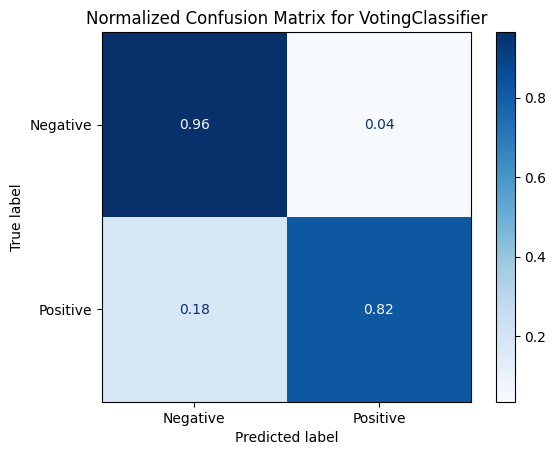

In [71]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Normalize the confusion matrix by dividing by the sum of each row (i.e., true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='.2f')  # Format the values with 2 decimal points
plt.title("Normalized Confusion Matrix for VotingClassifier")
plt.show()


### Adding the Voting Classifier to the Final Pipeline

In this step, the **VotingClassifier** is added as the final step in the existing preprocessing pipeline:

1. **Adding the VotingClassifier:**
   - The **VotingClassifier** is appended to the list of steps in the pipeline (`model_steps`). This creates a new pipeline (`model`) that combines the existing preprocessing steps with the classifier.

2. **Preparing the Full Training Data:**
   - The target variable **'Depression'** is separated from the full dataset (`data["Depression"]`), and the features are stored in `X_train_full` by dropping the 'Depression' column from the dataset.

3. **Fitting the Full Model:**
   - The pipeline is fitted using the full training data (`X_train_full` and `y_train_full`). This fits all preprocessing steps, including the VotingClassifier, to the data.

The result is a complete model pipeline, ready to be used for training on the full dataset.


In [ ]:
#Add the VotingClassifier as the final step
model_steps = pipeline.steps + [('voting_clf', voting_clf)]

# Create the model from the updated steps list
model = Pipeline(steps=model_steps)

y_train_full = data["Depression"] 
X_train_full = data.drop(columns=["Depression"])



# Now you can fit the pipeline and make predictions
model.fit(X_train_full, y_train_full)

In [74]:
X_test = pipeline.fit_transform(test_data)

# Making Predictions on Test Data and Saving the Results

In this step, the trained model is used to make predictions on the **test data**:

1. **Making Predictions:**
   - The `predict()` method is used on the fitted **pipeline model** to make predictions on the test data (`test_data`). The predictions are stored in `test_pred`, which contains the predicted values for the 'Depression' target.

2. **Creating the Output DataFrame:**
   - An **output DataFrame** is created with two columns:
     - **'id'**: The 'id' column from the test data to uniquely identify each prediction.
     - **'Depression'**: The predicted values (`test_pred`) for the 'Depression' target.

3. **Saving the Results to a CSV File:**
   - The **output DataFrame** is saved to a CSV file (`submission.csv`) using the `to_csv()` method, with `index=False` to exclude the index column.

4. **Displaying the Output:**
   - The first few rows of the output DataFrame are displayed using `output.head()` to confirm the format of the saved predictions.

This process prepares the predictions for submission, making them ready for evaluation or submission in a competition.


In [75]:
test_pred = voting_clf.predict(X_test)

output = pd.DataFrame({'id': test_data['id'],
                       'Depression': test_pred})

# Save the output DataFrame to a CSV file
output.to_csv('submission.csv', index=False)

output.head()

id  Depression
0  140700           0
1  140701           0
2  140702           0
3  140703           1
4  140704           0